# Spec2Vec - Find similar compounds for unknown substances
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

### Import pre-processed dataset "AllPositive"

In [2]:
import pickle
from matchms.importing import load_from_json
outfile = os.path.join(path_data, 'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        spectrums = pickle.load(inf)
else:
    filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
    spectrums = load_from_json(filename)
    with open(outfile, 'wb') as outf:
        pickle.dump(spectrums, outf)

print("number of spectra:", len(spectrums))

C:\Users\joris\Documents\eScience_data\data\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle
number of spectra: 112956


In [7]:
#loading data as pickled object goes a lot quicker
import time
print(outfile)
start = time.time()
with open(outfile, 'rb') as inf:
        spectrums = pickle.load(inf)
end = time.time()
print('loading took {:.2f} s'.format(end-start))

C:\Users\joris\Documents\eScience_data\data\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle
loading took 29.74 s


Text(0, 0.5, 'number of spectra in respective bin')

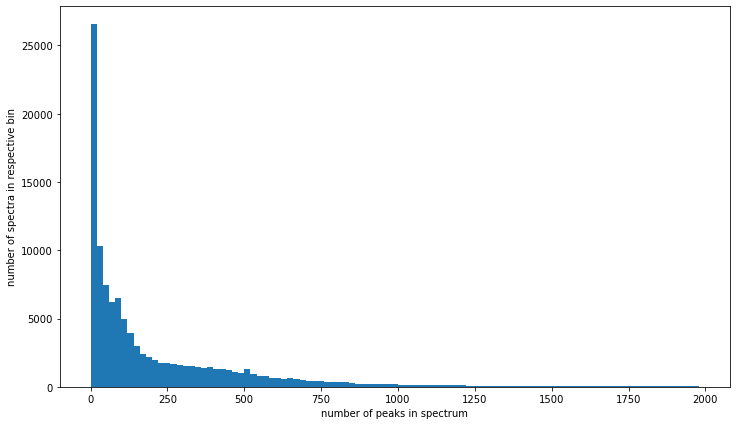

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-process data
We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

#### Post-processing for classical scores
Cosine and modified cosine scores are build on multiplying intensities of matching peaks. Small peaks (<0.01) hence contribute very little to the final scores and are left out to avoid excessive computation times. 
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ remove peaks with intensities < 0.01 of maximum intensity.

#### Post-processing for Spec2Vec
Spec2Vec similarity scores rely on creating a ``document vector`` for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ reduce number of peaks to maximum of 0.5 * parent mass
+ remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

95320 remaining spectra.


Text(0, 0.5, 'number of spectra in respective bin')

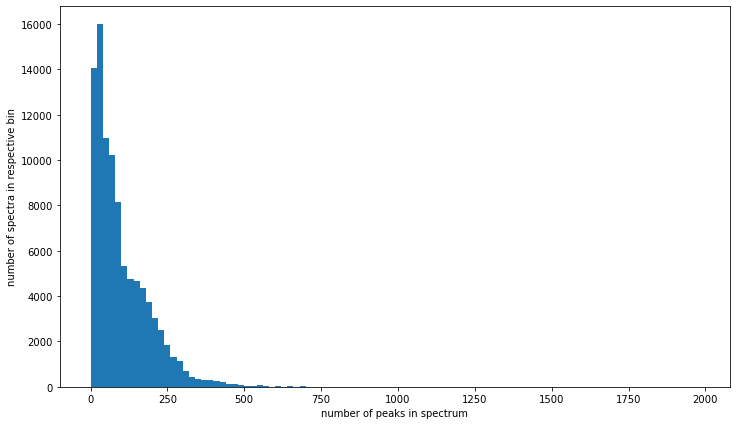

In [10]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [7]:
np.max(number_of_peaks)

1081

## Inspect annotations

In [5]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

In [12]:
Inchikeys[:10]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N']

In [6]:
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:30]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
IQGPMZRCLCCXAG    308
WTJKGGKOPKCXLL    295
IIZPXYDJLKNOIY    235
RWKUXQNLWDTSLO    234
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    210
KILNVBDSWZSGLL    205
RFVFQQWKPSOBED    202
IESVDEZGAHUQJU    197
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
LSOWKZULVQWMLY    180
XGGMHQYOVYWRLV    178
LLHISNQVRRYJGL    175
JFISYPWOVQNHLS    174
SRIGHEHXEGELQJ    166
ACTIUHUUMQJHFO    163
PZNPLUBHRSSFHT    162
YLWSJLLZUHSIEA    158
GPWHCUUIQMGELX    150
BLZVZPYMHLXLHG    148
QEDPUVGSSDPBMD    146
IGZPHNNYPPAPLA    142
CITHEXJVPOWHKC    141
SXNXGNVZTLZDHE    131
YEJYLHKQOBOSCP    131
AXZGUCXCTZMPTR    128
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

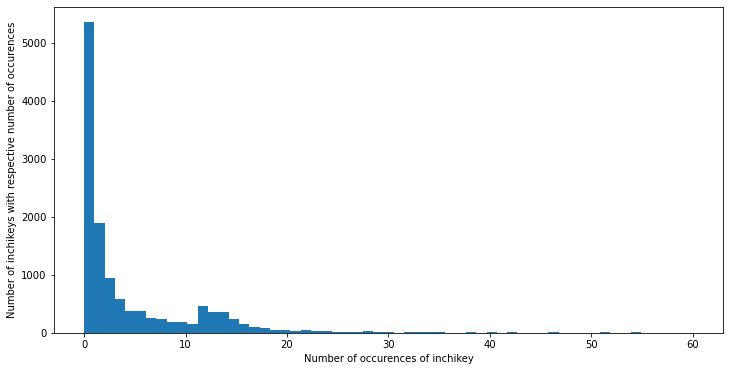

In [14]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

In [7]:
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

inchikey14  occurences
0   NEGQHKSYEYVFTD         432
1   SULIDBRAXVDKBU         426
2   IQGPMZRCLCCXAG         308
3   WTJKGGKOPKCXLL         295
4   IIZPXYDJLKNOIY         235
5   RWKUXQNLWDTSLO         234
6   QIBZFHLFHCIUOT         225
7   ZAYXPDDGEIJGGW         212
8   QJWDAOSZZYVBJZ         210
9   KILNVBDSWZSGLL         205
10  RFVFQQWKPSOBED         202
11  IESVDEZGAHUQJU         197
12  LFUDDCMNKWEORN         195
13  JLPULHDHAOZNQI         182
14  LSOWKZULVQWMLY         180

In [16]:
print("Number of spectra with inchikeys that exist >= 5 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 5 times: 4079


### Randomly select 1000 inchikeys that exist >=5  times in the dataset

In [8]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[  33 3233 1556 2547  457 3598  857 1878  705  803 1642  495 2866 1034
 1517  564 2826  568 2575 3956  670 3317 1498 2971   96]


array(['SRRQPVVYXBTRQK', 'JUZYLCPPVHEVSV', 'UZXMLGUMBQQVME',
       'PDAKXMIQFUHWQC', 'JFVKWCYZKMUTLH', 'HQPCSDADVLFHHO',
       'HUPGTAGQEXENPN', 'YPKUMLKVFXFYOT', 'KWIUHFFTVRNATP',
       'QJVXKWHHAMZTBY', 'PGERTGWKXFAEFR', 'MIHLTJZHRJACQQ',
       'YFAGHNZHGGCZAX', 'LKWWJGGLULNRBP', 'XWTYSIMOBUGWOL',
       'BPEXJHGGARTCIR', 'FHHVIBPVBBRLOR', 'YFPYXTNSQOUHPS',
       'LTLYEAJONXGNFG', 'INOGLHRUEYDAHX', 'VGOJYSUPEJWUNN',
       'BPICBUSOMSTKRF', 'ZQHJXKYYELWEOK', 'MXHRCPNRJAMMIM',
       'QXMHHXQBBKDSSL'], dtype=object)

In [9]:
#Randomly select another 1000 inchikeys that exist >=5 times in the dataset and don't occur in the first list selected_inchikeys
new_suitable_inchikeys = suitable_inchikeys.copy()
drop_selection = suitable_inchikeys.index[selection] #get index names of first selection
new_suitable_inchikeys.drop(drop_selection, inplace = True) #remove first selection
print(new_suitable_inchikeys.shape[0])
print('Number of old selected inchikeys in new list:',len(set(new_suitable_inchikeys['inchikey14']) & set(selected_inchikeys)))

np.random.seed(42) # to make it reproducible
new_selection = np.random.choice(new_suitable_inchikeys.shape[0], num_spectra, replace=False)
print(new_selection[:25], len(new_selection))
new_selected_inchikeys = new_suitable_inchikeys['inchikey14'].values[new_selection]
print('Overlap between new and old list:', len(set(new_selected_inchikeys) & set(selected_inchikeys)))

3079
Number of old selected inchikeys in new list: 0
[  63 2775 2016  331 2739  594 2244  346 2312 1472 2785  194 2370 2032
 2538  246  256  486  978 1961  144  801  744  457  416] 1000
Overlap between new and old list: 0


In [10]:
#Randomly select another 1000 inchikeys that exist >=5 times in the dataset and don't occur in the first two lists
new2_suitable_inchikeys = new_suitable_inchikeys.copy()
new2_drop_selection = new_suitable_inchikeys.index[new_selection] #get index names of first selection
new2_suitable_inchikeys.drop(new2_drop_selection, inplace = True) #remove first selection
print(new2_suitable_inchikeys.shape[0])
print('Number of old selected inchikeys in new list:',len(set(new2_suitable_inchikeys['inchikey14']) & set(new_selected_inchikeys)))

np.random.seed(42) # to make it reproducible
new2_selection = np.random.choice(new2_suitable_inchikeys.shape[0], num_spectra, replace=False)
print(new2_selection[:25], len(new2_selection))
new2_selected_inchikeys = new2_suitable_inchikeys['inchikey14'].values[new2_selection]
print('Overlap between new and old list:', len(set(new2_selected_inchikeys) & set(new_selected_inchikeys)))

2079
Number of old selected inchikeys in new list: 0
[1362 2004  607   29  429  861  109  693  432   51 1969 1389 1532  354
  188 1972  251 1229  571 1916  561  342 1548 2031 1292] 1000
Overlap between new and old list: 0


In [11]:
#Randomly select another 1000 inchikeys that exist >=5 times in the dataset and don't occur in the first two lists
new3_suitable_inchikeys = new2_suitable_inchikeys.copy()
new3_drop_selection = new2_suitable_inchikeys.index[new2_selection] #get index names of first selection
new3_suitable_inchikeys.drop(new3_drop_selection, inplace = True) #remove first selection
print(new3_suitable_inchikeys.shape[0])
print('Number of old selected inchikeys in new list:',len(set(new3_suitable_inchikeys['inchikey14']) & set(new2_selected_inchikeys)))

np.random.seed(42) # to make it reproducible
new3_selection = np.random.choice(new3_suitable_inchikeys.shape[0], num_spectra, replace=False)
print(new3_selection[:25], len(new3_selection))
new3_selected_inchikeys = new3_suitable_inchikeys['inchikey14'].values[new3_selection]
print('Overlap between new and old list:', len(set(new3_selected_inchikeys) & set(new2_selected_inchikeys)))

1079
Number of old selected inchikeys in new list: 0
[ 423  548  730  588  830  616  989  991  950 1004  728  581  634  158
  365  448  333  495  910  937   56   70  485  388  528] 1000
Overlap between new and old list: 0


### Randomly pick 1000 inchikeys (spectra) that are unqiue in the dataset

In [12]:
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
unique_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values == 1])

unique_inchikeys.reset_index(level=unique_inchikeys.index.names, inplace=True)
unique_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
unique_inchikeys = unique_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
unique_inchikeys.head(15)

inchikey14  occurences
3285  ZZYHCCDMBJTROG           1
67    ZZTCNNZHOWDRPS           1
4149  ZZQHNBGRWRQWFI           1
3168  ZZPAWQYZQVUVHX           1
3736  ZZNVCZGRNCQHCQ           1
1629  ZZHLYYDVIOPZBE           1
4919  ZZAJQOPSWWVMBI           1
2303  ZYYNEJWFGGVJQZ           1
1415  ZYVYPNZFOCZLEM           1
5309  ZYUDDSCUGFXAKK           1
822   ZYTHYMZQQBWDDS           1
1031  ZYGYNVJVDLQWDG           1
1222  ZYGSNVAGWKWKKI           1
1789  ZYEMGPIYFIJGTP           1
1905  ZXZPFGGUUZDXND           1

In [37]:
print(len(unique_inchikeys))

5352


In [13]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
unique_selection = np.random.choice(unique_inchikeys.shape[0], num_spectra, replace=False)
print(unique_selection[:25])
selected_unique_inchikeys = unique_inchikeys['inchikey14'].values[unique_selection]
print(selected_unique_inchikeys[:25])

#get the spectrum that belongs with the unique chosen inchikeys
selected_unique_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_unique_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_unique_spectra.append(int(matches[0]))
print(len(selected_unique_spectra))

[4114 1650  401 4221 1684   33  290 3265 5324 3235 4213 3403 5004 3699
 1075  925 4074 4446 2642 2972  810 3204 3872 2707 2651]
['GQIJYUMTOUBHSH' 'RVWQXFWAUMMLKE' 'YGULWPYYGQCFMP' 'GDPHPXYFLPDZGH'
 'RRNSPXUFTKJIEZ' 'ZWNKGUOHTAKRBN' 'YTNXARXLPJGCHV' 'KMRZMOYMAAVHNA'
 'ADDCNOCQPWDJSR' 'KQFUXLQBMQGNRT' 'GEJNVNUFFYATKR' 'JVRVKOOOXHGJKI'
 'BOVRCQYBOHNUIF' 'INOKSQLHQGQUNF' 'VGGCLGHLLZKCSW' 'VYGQXRZAHIZHQV'
 'GUOQUXNJZHGPQF' 'FAZKBTFQSATIIN' 'NISZLIJBKRGIAU' 'LVUQCTGSDJLWCE'
 'WMAITHDYVBQITD' 'KSZJPQHIPKEEMF' 'HSLDNQNDHKZKNZ' 'NBLBCGUCPBXKOV'
 'NHNODHRSCRALBF']
1000


In [38]:
#Randomly select another 1000 inchikeys that are unique in the dataset and don't occur in the first list selected_unique_inchikeys
new_unique_inchikeys = unique_inchikeys.copy()
drop_selection = unique_inchikeys.index[unique_selection] #get index names of first selection
new_unique_inchikeys.drop(drop_selection, inplace = True) #remove first selection
print(new_unique_inchikeys.shape[0])
print('Number of old selected inchikeys in new list:',len(set(new_unique_inchikeys['inchikey14']) & set(selected_unique_inchikeys)))

np.random.seed(42) # to make it reproducible
new_unique_selection = np.random.choice(new_unique_inchikeys.shape[0], num_spectra, replace=False)
print(new_unique_selection[:25], len(new_unique_selection))
new_selected_unique_inchikeys = new_unique_inchikeys['inchikey14'].values[new_unique_selection]
print('Overlap between new and old list:', len(set(new_selected_unique_inchikeys) & set(selected_unique_inchikeys)))

#get the spectrum that belongs with the unique chosen inchikeys
new_selected_unique_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in new_selected_unique_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    new_selected_unique_spectra.append(int(matches[0]))
print(len(new_selected_unique_spectra))

4352
Number of old selected inchikeys in new list: 0
[ 505 1611 3107  511 1467  410 3678 2677 3370 4235 3853 3217  149 4332
 1295 2457 2589 1261  287 3038   17  755  305 3276 4084] 1000
Overlap between new and old list: 0
1000


### Randomly pick one spectra for each of the chosen inchikeys

In [14]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [15]:
#add unique dataset together with old test set of 1000 spectra >5 occurrence
old_and_unique_test_set = selected_spectra + selected_unique_spectra
len(old_and_unique_test_set)

2000

In [25]:
selected_spectra[:10]

[52728, 6129, 78135, 62556, 73314, 21762, 12492, 88980, 63188, 74380]

In [26]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_s2v[ID].get("spectrumid"),
         spectrums_s2v[ID].get("inchikey")[:14])

CCMSLIB00003128874 SRRQPVVYXBTRQK
CCMSLIB00000005841 JUZYLCPPVHEVSV
CCMSLIB00004701389 UZXMLGUMBQQVME
CCMSLIB00000215466 PDAKXMIQFUHWQC
CCMSLIB00004695353 JFVKWCYZKMUTLH
CCMSLIB00003136589 HQPCSDADVLFHHO
CCMSLIB00000850213 HUPGTAGQEXENPN
CCMSLIB00004715739 YPKUMLKVFXFYOT
CCMSLIB00000217500 KWIUHFFTVRNATP
CCMSLIB00004696689 QJVXKWHHAMZTBY


In [16]:
#Pick one spectrum for each of the new chosen inchikeys
new_selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in new_selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    new_selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [39]:
#add second unique test set together with new test set of 1000 spectra >5 occurrence
new_and_unique2_test_set = new_selected_spectra + new_selected_unique_spectra

In [17]:
#Pick one spectrum for each of the new chosen inchikeys
new2_selected_spectra = []
new3_selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in new2_selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    new2_selected_spectra.append(int(np.random.choice(matches,1)[0]))

np.random.seed(42) # to make it reproducible
for inchikey in new3_selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    new3_selected_spectra.append(int(np.random.choice(matches,1)[0]))

## Train new model on AllPositive dataset WITHOUT selected spectra

In [18]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model

In [242]:
outfile = os.path.join(path_data, 'documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        documents_library_s2v = pickle.load(inf)
else:
    documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in selected_spectra]
    with open(outfile, 'wb') as outf:
        pickle.dump(documents_library_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\documents_library_s2v.pickle


In [241]:
outfile = os.path.join(path_data, 'new_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_documents_library_s2v = pickle.load(inf)
else:
    new_documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in new_selected_spectra]
    with open(outfile, 'wb') as outf:
        pickle.dump(new_documents_library_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\new_documents_library_s2v.pickle


In [27]:
outfile = os.path.join(path_data, 'old_and_unique_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_documents_library_s2v = pickle.load(inf)
else:
    old_and_unique_documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in old_and_unique_test_set]
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_documents_library_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\old_and_unique_documents_library_s2v.pickle


In [40]:
outfile = os.path.join(path_data, 'new_and_unique2_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_library_s2v = pickle.load(inf)
else:
    new_and_unique2_documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in new_and_unique2_test_set]
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_documents_library_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_library_s2v.pickle


In [19]:
new2_documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in new2_selected_spectra]
new3_documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in new3_selected_spectra]

In [92]:
print(len(documents_library_s2v), len(spectrums_s2v))  # 1000 should be removed
print(len(new_documents_library_s2v), len(spectrums_s2v))

94320 95320
94320 95320


In [23]:
#from spec2vec.model_building import train_new_word2vec_model

#path_models = os.path.join(path_data, "trained_models")
#model_file = os.path.join(path_models, "spec2vec_librarymatching.model")

#iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
#model = train_new_word2vec_model(documents_library_s2v, iterations, model_file)

In [24]:
#train new model on allpositive without new selected spectra

#from spec2vec.model_building import train_new_word2vec_model

#path_models = os.path.join(path_data, "trained_models")
#new_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew.model")

#iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
#model = train_new_word2vec_model(new_documents_library_s2v, iterations, new_model_file)

In [162]:
#train new model on allpositive without new selected spectra

#path_models = os.path.join(path_data, "trained_models")
#new2_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew2.model")

#iterations = [15]

# Train model with default parameters
#new2_model = train_new_word2vec_model(new2_documents_library_s2v, iterations, new2_model_file)

  Epoch 1 of 15.Change in loss after epoch 1: 5733627.0
  Epoch 2 of 15.Change in loss after epoch 2: 4333161.0
  Epoch 3 of 15.Change in loss after epoch 3: 3833238.0
  Epoch 4 of 15.Change in loss after epoch 4: 3488840.0
  Epoch 5 of 15.Change in loss after epoch 5: 2988288.0
  Epoch 6 of 15.Change in loss after epoch 6: 2856058.0
  Epoch 7 of 15.Change in loss after epoch 7: 2714448.0
  Epoch 8 of 15.Change in loss after epoch 8: 2641868.0
  Epoch 9 of 15.Change in loss after epoch 9: 2599070.0
  Epoch 10 of 15.Change in loss after epoch 10: 2443018.0
  Epoch 11 of 15.Change in loss after epoch 11: 1529916.0
  Epoch 12 of 15.Change in loss after epoch 12: 1528688.0
  Epoch 13 of 15.Change in loss after epoch 13: 1493040.0
  Epoch 14 of 15.Change in loss after epoch 14: 1482232.0
  Epoch 15 of 15.Change in loss after epoch 15: 1452728.0
Saving model with name: C:\Users\joris\Documents\eScience_data\data\trained_models\spec2vec_librarymatchingnew2.model


In [163]:
#train new model on allpositive without new selected spectra

#path_models = os.path.join(path_data, "trained_models")
#new3_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew3.model")

#iterations = [15]

# Train model with default parameters
#new3_model = train_new_word2vec_model(new3_documents_library_s2v, iterations, new3_model_file)

  Epoch 1 of 15.Change in loss after epoch 1: 5815822.5
  Epoch 2 of 15.Change in loss after epoch 2: 4332776.5
  Epoch 3 of 15.Change in loss after epoch 3: 3774687.0
  Epoch 4 of 15.Change in loss after epoch 4: 3533044.0
  Epoch 5 of 15.Change in loss after epoch 5: 2944196.0
  Epoch 6 of 15.Change in loss after epoch 6: 2837714.0
  Epoch 7 of 15.Change in loss after epoch 7: 2680200.0
  Epoch 8 of 15.Change in loss after epoch 8: 2607796.0
  Epoch 9 of 15.Change in loss after epoch 9: 2579052.0
  Epoch 10 of 15.Change in loss after epoch 10: 2487492.0
  Epoch 11 of 15.Change in loss after epoch 11: 1563744.0
  Epoch 12 of 15.Change in loss after epoch 12: 1518200.0
  Epoch 13 of 15.Change in loss after epoch 13: 1509912.0
  Epoch 14 of 15.Change in loss after epoch 14: 1466700.0
  Epoch 15 of 15.Change in loss after epoch 15: 1430540.0
Saving model with name: C:\Users\joris\Documents\eScience_data\data\trained_models\spec2vec_librarymatchingnew3.model


In [164]:
#train new model on allpositive without 1000 spectra >5 occurrence and 1000 unique spectra

#path_models = os.path.join(path_data, "trained_models")
#old_and_unique_model_file = os.path.join(path_models, "spec2vec_librarymatching_plus_unique.model")

#iterations = [15]

# Train model with default parameters
#old_and_unique_model = train_new_word2vec_model(old_and_unique_documents_library_s2v, iterations, old_and_unique_model_file)

  Epoch 1 of 15.Change in loss after epoch 1: 5658305.5
  Epoch 2 of 15.Change in loss after epoch 2: 4313616.5
  Epoch 3 of 15.Change in loss after epoch 3: 3782774.0
  Epoch 4 of 15.Change in loss after epoch 4: 3483726.0
  Epoch 5 of 15.Change in loss after epoch 5: 2885978.0
  Epoch 6 of 15.Change in loss after epoch 6: 2798772.0
  Epoch 7 of 15.Change in loss after epoch 7: 2649280.0
  Epoch 8 of 15.Change in loss after epoch 8: 2627094.0
  Epoch 9 of 15.Change in loss after epoch 9: 2497248.0
  Epoch 10 of 15.Change in loss after epoch 10: 2407102.0
  Epoch 11 of 15.Change in loss after epoch 11: 1683920.0
  Epoch 12 of 15.Change in loss after epoch 12: 1479412.0
  Epoch 13 of 15.Change in loss after epoch 13: 1437412.0
  Epoch 14 of 15.Change in loss after epoch 14: 1446216.0
  Epoch 15 of 15.Change in loss after epoch 15: 1420592.0
Saving model with name: C:\Users\joris\Documents\eScience_data\data\trained_models\spec2vec_librarymatching_plus_unique.model


In [41]:
#train new model on allpositive without 1000 spectra >5 occurrence and 1000 unique spectra

path_models = os.path.join(path_data, "trained_models")
new_and_unique2_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew_plus_unique2.model")

iterations = [15]

# Train model with default parameters
new_and_unique2_model = train_new_word2vec_model(new_and_unique2_documents_library_s2v, iterations, new_and_unique2_model_file)

  Epoch 1 of 15.Change in loss after epoch 1: 5690089.0
  Epoch 2 of 15.Change in loss after epoch 2: 4205896.0
  Epoch 3 of 15.Change in loss after epoch 3: 3737722.0
  Epoch 4 of 15.Change in loss after epoch 4: 3461079.0
  Epoch 5 of 15.Change in loss after epoch 5: 2867512.0
  Epoch 6 of 15.Change in loss after epoch 6: 2762174.0
  Epoch 7 of 15.Change in loss after epoch 7: 2642014.0
  Epoch 8 of 15.Change in loss after epoch 8: 2542064.0
  Epoch 9 of 15.Change in loss after epoch 9: 2485120.0
  Epoch 10 of 15.Change in loss after epoch 10: 2422124.0
  Epoch 11 of 15.Change in loss after epoch 11: 1823130.0
  Epoch 12 of 15.Change in loss after epoch 12: 1482092.0
  Epoch 13 of 15.Change in loss after epoch 13: 1452004.0
  Epoch 14 of 15.Change in loss after epoch 14: 1402236.0
  Epoch 15 of 15.Change in loss after epoch 15: 1394148.0
Saving model with name: C:\Users\joris\Documents\eScience_data\data\trained_models\spec2vec_librarymatchingnew_plus_unique2.model


## Actual library matching

In [20]:
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

In [21]:
from library_search import library_matching

#### Load word2vec model

In [22]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [28]:
print(model)


Word2Vec(vocab=115910, size=300, alpha=0.025)


In [ ]:
documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]
outfile = os.path.join(path_data, 'documents_query_s2v.pickle')
print(outfile)
if not os.path.exists(outfile):
    with open(outfile, 'wb') as outf:
        pickle.dump(documents_query_s2v, outf)

In [96]:
len(documents_query_s2v)

1000

In [31]:
documents_query_s2v[0]._obj.get("inchikey")

'SRRQPVVYXBTRQK-XMMPIXPASA-N'

In [218]:
#new model
outfile = os.path.join(path_data, 'new_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_documents_query_s2v = pickle.load(inf)
else:
    new_documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in new_selected_spectra]
    with open(outfile, 'wb') as outf:
        pickle.dump(new_documents_query_s2v, outf)

path_models = os.path.join(path_data, "trained_models")
new_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew_iter_15.model")
new_model = gensim.models.Word2Vec.load(model_file)

C:\Users\joris\Documents\eScience_data\data\new_documents_query_s2v.pickle


In [99]:
#new models
new2_documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in new2_selected_spectra]
path_models = os.path.join(path_data, "trained_models")
new2_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew2.model")
new2_model = gensim.models.Word2Vec.load(new2_model_file)

#number 3
new3_documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in new3_selected_spectra]
path_models = os.path.join(path_data, "trained_models")
new3_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew3.model")
new3_model = gensim.models.Word2Vec.load(new3_model_file)

In [28]:
#with unique
outfile = os.path.join(path_data, 'old_and_unique_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_documents_query_s2v = pickle.load(inf)
else:
    old_and_unique_documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in old_and_unique_test_set]
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_documents_query_s2v, outf)

path_models = os.path.join(path_data, "trained_models")
old_and_unique_model_file = os.path.join(path_models, "spec2vec_librarymatching_plus_unique.model")
old_and_unique_model = gensim.models.Word2Vec.load(old_and_unique_model_file)

C:\Users\joris\Documents\eScience_data\data\old_and_unique_documents_query_s2v.pickle


In [42]:
#new with unique2
outfile = os.path.join(path_data, 'new_and_unique2_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_query_s2v = pickle.load(inf)
else:
    new_and_unique2_documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in new_and_unique2_test_set]
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_documents_query_s2v, outf)

path_models = os.path.join(path_data, "trained_models")
new_and_unique2_model_file = os.path.join(path_models, "spec2vec_librarymatchingnew_plus_unique2.model")
new_and_unique2_model = gensim.models.Word2Vec.load(new_and_unique2_model_file)

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_query_s2v.pickle


### Correct a few (< 10) spectrums with missing precursor_mz (in place)

In [24]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1000 against 94320 spectra

In [31]:
import pickle
outfile = os.path.join(path_data, 'found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v = pickle.load(inf)
else:
    found_matches_s2v = library_matching(documents_query_s2v, documents_library_s2v,
                                     model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(found_matches_s2v, outf)

Pre-selection includes spec2vec top 20.


In [151]:
new_found_matches_s2v = library_matching(new_documents_query_s2v, new_documents_library_s2v,
                                     new_model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)

Pre-selection includes spec2vec top 20.


In [101]:
new2_found_matches_s2v = library_matching(new2_documents_query_s2v, new2_documents_library_s2v,
                                     new2_model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)
new3_found_matches_s2v = library_matching(new3_documents_query_s2v, new3_documents_library_s2v,
                                     new3_model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)

Pre-selection includes spec2vec top 20.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 1.79%.
Pre-selection includes spec2vec top 20.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.51%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 5 word(s) missing in the model. Weighted fraction not c

In [25]:
import pickle
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v = pickle.load(inf)
else:
    old_and_unique_found_matches_s2v = library_matching(old_and_unique_documents_query_s2v, old_and_unique_documents_library_s2v,
                                     old_and_unique_model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v, outf)

Pre-selection includes spec2vec top 20.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.09%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing 

In [46]:
import pickle
outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    new_and_unique2_found_matches_s2v = library_matching(new_and_unique2_documents_query_s2v, new_and_unique2_documents_library_s2v,
                                     new_and_unique2_model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=30.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v.pickle
Pre-selection includes spec2vec top 20.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.26%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 6.32%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.29%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.07%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 8.16%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 21.90%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.17%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.51%.


In [36]:
new_found_matches_s2v[0].sort_values(by=['s2v_score'],ascending=False)

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46341      0.792853               3          0.792853                   3   
52743      0.766401               1          0.766401                   1   
34539      0.241939               1          0.955195                   2   
47562      0.010289               1          0.010289                   1   
35469      0.243206               1          0.243206                   1   
...             ...             ...               ...                 ...   
14676      0.000000               0          0.012161                   1   
3754       0.000000               0          0.000000                   0   
69274      0.000000               0          0.000000                   0   
81463      0.000000               0          0.000000                   0   
81464      0.000000               0          0.000000                   0   

       mass_match  s2v_score  
46341         1.0   0.838697  
52743         0.0   0.589020  
34539         0.0   0.585604  
47562         1.0   0.584888  
35469         0.0   0.565561  
...           ...        ...  
14676         1.0  -0.049336  
3754          1.0  -0.049613  
69274         1.0  -0.052223  
81463         1.0  -0.055963  
81464         1.0  -0.070338  

[237 rows x 6 columns]

In [37]:
new_found_matches_s2v[0].sort_values(by=['s2v_score'],ascending=False)

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46341      0.792853               3          0.792853                   3   
52743      0.766401               1          0.766401                   1   
34539      0.241939               1          0.955195                   2   
47562      0.010289               1          0.010289                   1   
35469      0.243206               1          0.243206                   1   
...             ...             ...               ...                 ...   
14676      0.000000               0          0.012161                   1   
3754       0.000000               0          0.000000                   0   
69274      0.000000               0          0.000000                   0   
81463      0.000000               0          0.000000                   0   
81464      0.000000               0          0.000000                   0   

       mass_match  s2v_score  
46341         1.0   0.838697  
52743         0.0   0.589020  
34539         0.0   0.585604  
47562         1.0   0.584888  
35469         0.0   0.565561  
...           ...        ...  
14676         1.0  -0.049336  
3754          1.0  -0.049613  
69274         1.0  -0.052223  
81463         1.0  -0.055963  
81464         1.0  -0.070338  

[237 rows x 6 columns]

### How do the old and new test set compare?

In [39]:
from itertools import chain
old20_all_s2v_scores_list = [sorted(found_matches_s2v[i]['s2v_score'],reverse=True)[:20] for i in range(len(found_matches_s2v))]
old20_all_s2v_scores = list(chain.from_iterable(old20_all_s2v_scores_list))
new20_all_s2v_scores_list = [sorted(new_found_matches_s2v[i]['s2v_score'],reverse=True)[:20] for i in range(len(new_found_matches_s2v))]
new20_all_s2v_scores = list(chain.from_iterable(new20_all_s2v_scores_list))

old_all_s2v_scores_list = [found_matches_s2v[i]['s2v_score'] for i in range(len(found_matches_s2v))]
old_all_s2v_scores = list(chain.from_iterable(old_all_s2v_scores_list))
new_all_s2v_scores_list = [new_found_matches_s2v[i]['s2v_score'] for i in range(len(new_found_matches_s2v))]
new_all_s2v_scores = list(chain.from_iterable(new_all_s2v_scores_list))

len(old20_all_s2v_scores), len(new20_all_s2v_scores), len(old_all_s2v_scores), len(new_all_s2v_scores)

(20000, 20000, 239233, 241054)

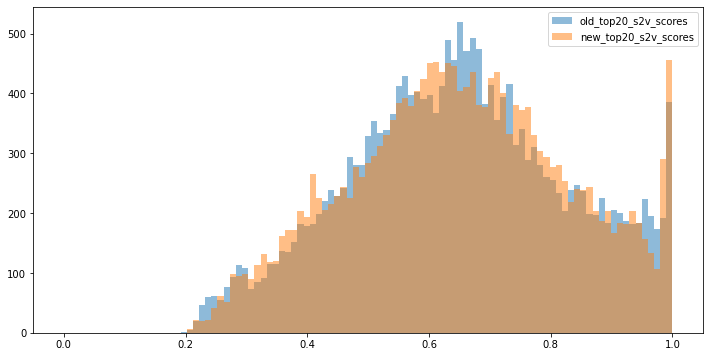

In [40]:
plt.figure(figsize=(12,6))
bns = np.linspace(0,1,100)
plt.hist(old20_all_s2v_scores, bins = bns, alpha=0.5, label='old_top20_s2v_scores')
plt.hist(new20_all_s2v_scores, bins = bns, alpha=0.5, label='new_top20_s2v_scores')
plt.legend(loc='upper right')
plt.show()

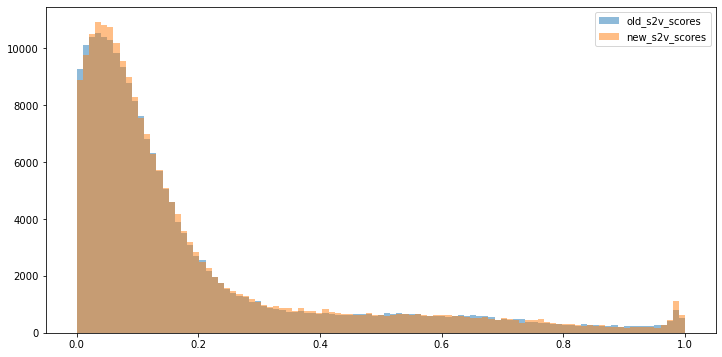

In [41]:
plt.figure(figsize=(12,6))
bns = np.linspace(0,1,100)
plt.hist(old_all_s2v_scores, bins = bns, alpha=0.5, label='old_s2v_scores')
plt.hist(new_all_s2v_scores, bins = bns, alpha=0.5, label='new_s2v_scores')
plt.legend(loc='upper right')
plt.show()

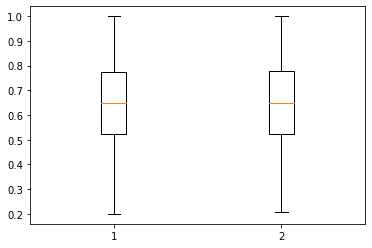

In [42]:
plt.boxplot([old20_all_s2v_scores, new20_all_s2v_scores])
plt.show()

In [43]:
compare_old_new20 = pd.DataFrame({'old20':old20_all_s2v_scores, 'new20':new20_all_s2v_scores})
compare_old_new20.describe()

old20         new20
count  20000.000000  20000.000000
mean       0.648347      0.650032
std        0.180152      0.180522
min        0.199394      0.206990
25%        0.522621      0.524059
50%        0.647679      0.648011
75%        0.774202      0.778094
max        1.000000      1.000000

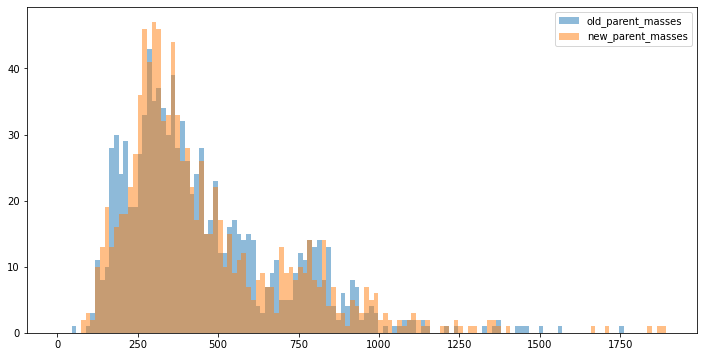

In [44]:
old_parent_masses = [documents_query_s2v[i]._obj.get('parent_mass') for i in range(len(documents_query_s2v))]
new_parent_masses = [new_documents_query_s2v[i]._obj.get('parent_mass') for i in range(len(new_documents_query_s2v))]
plt.figure(figsize=(12,6))
bns = np.linspace(0,max([mass for mass in (old_parent_masses+new_parent_masses)]), 130)
plt.hist(old_parent_masses, bins=bns, alpha=0.5, label='old_parent_masses')
plt.hist(new_parent_masses, bins=bns, alpha=0.5, label='new_parent_masses')
plt.legend(loc='upper right')
plt.show()

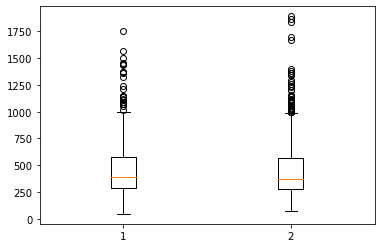

In [45]:
plt.boxplot([old_parent_masses,new_parent_masses])
plt.show()

In [46]:
pd.DataFrame({'old_parent_masses':old_parent_masses, 'new_parent_masses':new_parent_masses}).describe()

old_parent_masses  new_parent_masses
count        1000.000000        1000.000000
mean          453.683394         455.946632
std           245.729585         261.888464
min            44.992724          73.992724
25%           283.125974         280.148724
50%           387.216224         372.228224
75%           573.291974         563.890474
max          1756.982724        1892.562724

In [192]:
new_best_match_position = []
topn = 20
for match in new_found_matches_s2v_match_perc_pmass_sim:
    match = match.sort_values(by=['s2v_score'],ascending=False).iloc[:topn]
    for i in range(match.shape[0]):
        if match.iloc[i]['label'] == 1:
            new_best_match_position.append(i)
            break
new_best_match_position[:10], len(new_best_match_position)

([3, 0, 0, 0, 0, 0, 1, 11, 2, 2], 886)

In [193]:
best_match_position = []
for match in found_matches_s2v_match_perc_pmass_sim:
    match = match.sort_values(by=['s2v_score'],ascending=False).iloc[:topn]
    for i in range(match.shape[0]):
        if match.iloc[i]['label'] == 1:
            best_match_position.append(i)
            break
best_match_position[:10], len(best_match_position)

([0, 0, 0, 0, 0, 0, 0, 0, 1, 2], 898)

In [200]:
best_match_position.count(0)

720

                0
count  898.000000
mean     0.871938
std      2.672848
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     19.000000
                0
count  886.000000
mean     0.863431
std      2.541959
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     17.000000


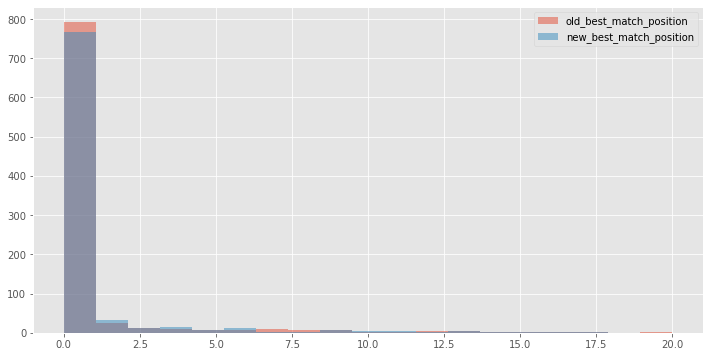

In [201]:
print(pd.DataFrame(best_match_position).describe())
print(pd.DataFrame(new_best_match_position).describe())
plt.figure(figsize=(12,6))
bns = np.linspace(0, 20, 20)
plt.hist(best_match_position, bins=bns, alpha=0.5, label='old_best_match_position')
plt.hist(new_best_match_position, bins=bns, alpha=0.5, label='new_best_match_position')
plt.legend(loc='upper right')
plt.show()

In [200]:
#the number of found true matches per query
new_num_matches = [match[match['label']==1].shape[0] for match in new_found_matches_s2v_match_perc_pmass_sim]
old_num_matches = [match[match['label']==1].shape[0] for match in found_matches_s2v_match_perc_pmass_sim]

In [201]:
pd.DataFrame({'new_fnum_matches_per_query':new_num_matches, 'old_fnum_matches_per_query':old_num_matches}).describe()

new_fnum_matches_per_query  old_fnum_matches_per_query
count                 1000.000000                  1000.00000
mean                     9.151000                    10.62700
std                     19.840964                    24.36213
min                      0.000000                     0.00000
25%                      3.000000                     3.00000
50%                      5.000000                     5.00000
75%                      9.000000                     9.00000
max                    425.000000                   431.00000

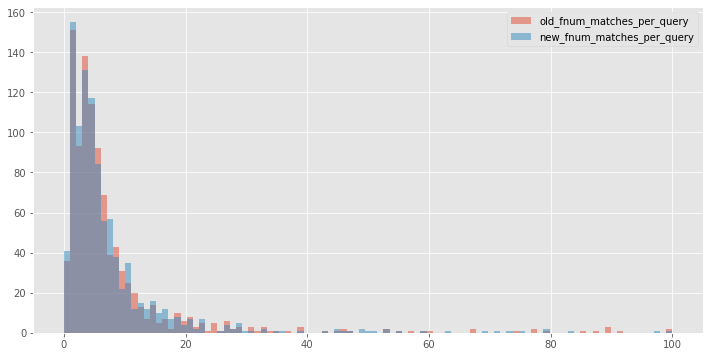

In [202]:
plt.figure(figsize=(12,6))
bns = np.linspace(0, 100, 100)
plt.hist(old_num_matches, bins=bns, alpha=0.5, label='old_fnum_matches_per_query')
plt.hist(new_num_matches, bins=bns, alpha=0.5, label='new_fnum_matches_per_query')
plt.legend(loc='upper right')
plt.show()

In [204]:
#the number of matching inchikey per query
new_all_true_matches = new_suitable_inchikeys['occurences'].values[new_selection]-1
old_all_true_matches = suitable_inchikeys['occurences'].values[selection]-1
pd.DataFrame({'old_all_true_matches':old_all_true_matches, 'new_all_true_matches':new_all_true_matches}).describe()

KeyError: 'occurences'

In [ ]:
plt.figure(figsize=(18,6))
bns = np.linspace(0, 200, 200)
plt.hist(old_all_true_matches, bins=bns, alpha=0.5, label='old_all_true_matches')
plt.hist(new_all_true_matches, bins=bns, alpha=0.5, label='new_all_true_matches')
plt.hist(suitable_inchikeys['occurences']-1, bins=bns, alpha=0.4, label='all_true_matches')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#do the best matches have mass match?
new_best_match_have_mm = []
for match in new_found_matches_s2v_match_perc_pmass_sim:
    match = match.sort_values(by=['s2v_score'],ascending=False)
    for i in range(match.shape[0]):
        if match.iloc[i]['label'] == 1:
            res = 0
            if match.iloc[i]['mass_match'] == 1:
                res = 1
            new_best_match_have_mm.append(res)
            break
print('Number of new best matches that has mass match:', new_best_match_have_mm.count(1))
print('Total of new best matches:', len(new_best_match_have_mm))

old_best_match_have_mm = []
for match in found_matches_s2v_match_perc_pmass_sim:
    match = match.sort_values(by=['s2v_score'],ascending=False)
    for i in range(match.shape[0]):
        if match.iloc[i]['label'] == 1:
            res = 0
            if match.iloc[i]['mass_match'] == 1:
                res = 1
            old_best_match_have_mm.append(res)
            break
print('Number of old best matches that has mass match:', old_best_match_have_mm.count(1))
print('Total of old best matches:', len(old_best_match_have_mm))

### Testing performance and training random forest models

In [102]:
threshold = 0.5
min_match = 1
ID = 0
df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                     & (found_matches_s2v[ID]['cosine_score'] > threshold)
                     & (found_matches_s2v[ID]['cosine_matches'] >= min_match)]
best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
print(best_match_ID)
print(documents_library_s2v[best_match_ID]._obj.get("inchikey"))
print(documents_query_s2v[ID]._obj.get("inchikey"))

46003
SRRQPVVYXBTRQK-XMMPIXPASA-N
SRRQPVVYXBTRQK-XMMPIXPASA-N


In [103]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print("Checking matches for S2V score >", threshold)
    test_matches = []
    
    for ID in range(len(documents_query_s2v)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                      & (found_matches_s2v[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for S2V score > 0.0
Checking matches for S2V score > 0.05
Checking matches for S2V score > 0.1
Checking matches for S2V score > 0.15000000000000002
Checking matches for S2V score > 0.2
Checking matches for S2V score > 0.25
Checking matches for S2V score > 0.30000000000000004
Checking matches for S2V score > 0.35000000000000003
Checking matches for S2V score > 0.4
Checking matches for S2V score > 0.45
Checking matches for S2V score > 0.5
Checking matches for S2V score > 0.55
Checking matches for S2V score > 0.6000000000000001
Checking matches for S2V score > 0.65
Checking matches for S2V score > 0.7000000000000001
Checking matches for S2V score > 0.75
Checking matches for S2V score > 0.8
Checking matches for S2V score > 0.8500000000000001
Checking matches for S2V score > 0.9
Checking matches for S2V score > 0.9500000000000001


Text(0, 0.5, 'true positives')

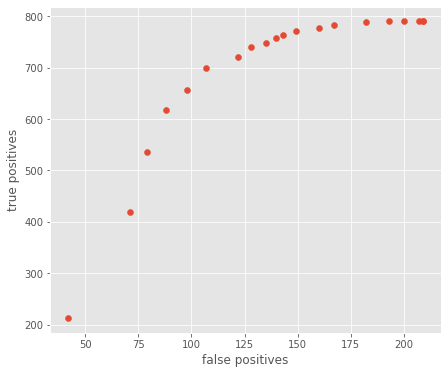

In [104]:
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [105]:
np.array(test_matches_s2v)[:,:]

array([[790, 209,   1],
       [790, 209,   1],
       [790, 207,   3],
       [790, 200,  10],
       [790, 193,  17],
       [789, 182,  29],
       [784, 167,  49],
       [778, 160,  62],
       [772, 149,  79],
       [764, 143,  93],
       [757, 140, 103],
       [748, 135, 117],
       [740, 128, 132],
       [721, 122, 157],
       [699, 107, 194],
       [657,  98, 245],
       [618,  88, 294],
       [536,  79, 385],
       [419,  71, 510],
       [213,  42, 745]])

In [106]:
#Trying to find a label of true or false positive for each query at a certain s2v score threshold
true_pos_s2v = []
false_pos_s2v = []
#df ends up as rows: query document number, cols: features (from found_matches) and true or false positive
best_matches_labeled_s2v = pd.DataFrame()

threshold = 0.4
print("Checking matches for S2V score >", threshold)

for ID in range(len(documents_query_s2v)):
    # Scenario 2: mass + sort by Spec2Vec
    df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                  & (found_matches_s2v[ID]['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0]
        best_match_ID = best_match.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]

        best_bet = 1 * (inchikey_selected == inchikey_query)
        
        best_match['label'] = best_bet
        best_match.rename(ID, inplace=True)
        best_matches_labeled_s2v = best_matches_labeled_s2v.append(best_match)
    else:
        best_bet = -1 # meaning: not found - not interesting in this case

    #record pairs
    if best_bet == 1:
        true_pos_s2v.append((ID, best_match_ID))
    elif best_bet == 0:
        false_pos_s2v.append((ID, best_match_ID)) #record best hit for false positive

Checking matches for S2V score > 0.4


In [107]:
print(len(true_pos_s2v), len(false_pos_s2v))
print(true_pos_s2v[0])
print(best_matches_labeled_s2v[best_matches_labeled_s2v['label']==0].iloc[0:10])

772 149
(0, 46003)
    cosine_matches  cosine_score  label  mass_match  mod_cosine_matches  \
8              4.0      0.474605    0.0         1.0                 4.0   
16             0.0      0.000000    0.0         1.0                 0.0   
18             7.0      0.000094    0.0         1.0                10.0   
22           134.0      0.717124    0.0         1.0               134.0   
46             9.0      0.987546    0.0         1.0                 9.0   
48            65.0      0.016529    0.0         1.0                72.0   
52            65.0      0.999897    0.0         1.0                65.0   
65           141.0      0.663807    0.0         1.0               140.0   
66            51.0      0.997571    0.0         1.0                51.0   
74             2.0      0.504692    0.0         1.0                 2.0   

    mod_cosine_score  s2v_score  
8           0.474605   0.480207  
16          0.000000   0.949601  
18          0.000190   0.478899  
22          0.71712

In [108]:
#store labels
labels = np.array(best_matches_labeled_s2v['label'])
#remove labels
best_matches_s2v = best_matches_labeled_s2v.drop('label', axis = 1)
feature_list = list(best_matches_s2v.columns)
best_matches_s2v = np.array(best_matches_s2v)

In [109]:
from sklearn.model_selection import train_test_split
#make training and testing sets
train_features, test_features,\
train_labels, test_labels = train_test_split(best_matches_s2v, labels,
                                             test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (690, 6)
Training Labels Shape: (690,)
Testing Features Shape: (231, 6)
Testing Labels Shape: (231,)


In [110]:
print(test_labels)
print("False positive rate test set: ", 1 - (np.sum(test_labels)/len(test_labels)))

[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
False positive rate test set:  0.16450216450216448


In [111]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [112]:
predictions = rf.predict(test_features)
print(predictions)
accuracy = sum(1 for test, pred in zip(test_labels, predictions) if test == pred) / len(test_labels)
print("Accuracy:", accuracy)
print("False positive rate predictions: ", 1 - (np.sum(predictions)/len(predictions)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy: 0.8311688311688312
False positive rate predictions:  0.030303030303030276


In [113]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: s2v_score            Importance: 0.25
Variable: cosine_score         Importance: 0.21
Variable: mod_cosine_score     Importance: 0.2
Variable: cosine_matches       Importance: 0.17
Variable: mod_cosine_matches   Importance: 0.17
Variable: mass_match           Importance: 0.0


In [114]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

def do_random_forest(feature_df, label_name, rf_regr = False, verbose = True, num_est = 1000):
    '''Split data in training and test, train rf, predict on test

    feature_df: pandas DataFrame
    label_name: str, name of the label column in feature_df
    rf_refr: bool, make a RandomForestRegressor model instead of Classifier
    verbose: bool, print more info
    num_est: int, n_estimators in RandomForestClassifiers
    
    Returns test_features, test_labels, predictions, rf
    '''
    #store labels
    labels = np.array(feature_df[label_name])
    #remove labels
    feature_df_nolab = feature_df.drop(label_name, axis = 1)
    feature_list = list(feature_df_nolab.columns)
    feature_df_nolab = np.array(feature_df_nolab)
    
    #split data in training and test set
    train_features, test_features,\
    train_labels, test_labels = train_test_split(feature_df_nolab, labels,
                                                 test_size = 0.25, random_state = 42)
    if verbose:
        print('Label distribution:', dict(zip(*np.unique(np.round(labels,1), return_counts=True))))
        print('Training Features Shape:', train_features.shape)
        print('Training Labels Shape:', train_labels.shape)
        print('Training label distribution:', dict(zip(*np.unique(np.round(train_labels,1), return_counts=True))))
        print('Testing Features Shape:', test_features.shape)
        print('Testing Labels Shape:', test_labels.shape)
        print('Test label distribution:', dict(zip(*np.unique(np.round(test_labels,1), return_counts=True))))
    
    #train model
    if not rf_regr:
        rf = RandomForestClassifier(n_estimators = num_est, random_state = 42)
    else: #make a rf regression model instead of classifier
        rf = RandomForestRegressor(n_estimators = num_est, random_state = 42)
    rf.fit(train_features, train_labels)
    
    #predict test set
    predictions = rf.predict(test_features)

    print('\nPredicted label distribution:', dict(zip(*np.unique(np.round(predictions,1), return_counts=True))))
    df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
    print('Predictions:','\n0->0','1->1')
    zero_to_zero = np.sum((df.Actual < 0.5) & (df.Predicted < 0.5))
    one_to_one = np.sum((df.Actual >= 0.5) & (df.Predicted >= 0.5))
    print(zero_to_zero, one_to_one)
    print('0->1','1->0')
    print(np.sum((df.Actual < 0.5) & (df.Predicted >= 0.5)), 
    np.sum((df.Actual >= 0.5) & (df.Predicted < 0.5)))
    print("Accuracy: {:.2f}\n".format((zero_to_zero + one_to_one)/len(predictions)))

    #get feature importances
    importances = list(rf.feature_importances_)
    #list of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    return (test_features, test_labels, predictions, rf)

In [115]:
def find_inchikey_matches(matches, documents_library, documents_query):
    '''To each df in matches, add label for matching inchikey (1) or non-matching (0)

    matches: list of pandas DataFrames, library matching result of query on library
    documents_library: list of SpectrumDocuments, spectra in library
    documents_query: list of SpectrumDocuments, spectra in query set.
        Indices should correspond to indices of matches.
    matches_with_labels: list of pandas DataFrames, library matching result of query
        on library with matching labels
    '''
    matches_with_labels = []
    for query_id in range(len(documents_query)):
        df = matches[query_id].copy()
        library_ids = df.index.values
        labels = []
        query_inchi = documents_query[query_id]._obj.get("inchikey")[:14]
        for lib_id in library_ids:
            lib_inchi = documents_library[lib_id]._obj.get("inchikey")[:14]
            lab = 0
            if query_inchi == lib_inchi:
                lab = 1
            labels.append(lab)
        df['label'] = labels
        matches_with_labels.append(df)
    return matches_with_labels

found_matches_s2v_labels = find_inchikey_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v)

### Take all hits and label true positives

In [116]:
found_matches_s2v_labels[1].sort_values("s2v_score", ascending = False)

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
6091       0.991375               4          0.991375                   4   
6100       0.444585               3          0.444585                   3   
6092       0.345093               4          0.345093                   4   
59577      0.000000               0          0.130303                   1   
59660      0.000000               0          0.105543                   1   
...             ...             ...               ...                 ...   
24360      0.000000               0          0.188801                   1   
24038      0.000000               0          0.158695                   1   
9790       0.000000               0          0.000000                   0   
3256       0.000000               0          0.000000                   0   
6013       0.000000               0          0.000000                   0   

       mass_match  s2v_score  label  
6091          1.0   0.940499      1  
6100          1.0   0.896288      1  
6092          1.0   0.874877      1  
59577         0.0   0.741305      0  
59660         0.0   0.738891      0  
...           ...        ...    ...  
24360         1.0  -0.072580      0  
24038         1.0  -0.075708      0  
9790          1.0  -0.077540      0  
3256          1.0  -0.078467      0  
6013          1.0  -0.139723      0  

[329 rows x 7 columns]

In [117]:
all_matches_s2v_labels = found_matches_s2v_labels[0].append(found_matches_s2v_labels[1:])
print(all_matches_s2v_labels.shape, sum(df.shape[0] for df in found_matches_s2v_labels))

(239233, 7) 239233


In [118]:
all_result = do_random_forest(all_matches_s2v_labels, 'label', verbose = True, num_est = 200)

Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 6)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 6)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {0: 57827, 1: 1982}
Predictions: 
0->0 1->1
56247 1053
0->1 1->0
929 1580
Accuracy: 0.96

Variable: s2v_score            Importance: 0.46
Variable: cosine_score         Importance: 0.18
Variable: mod_cosine_score     Importance: 0.16
Variable: mod_cosine_matches   Importance: 0.07
Variable: mass_match           Importance: 0.07
Variable: cosine_matches       Importance: 0.06


In [119]:
def make_s2v_selection(matches, topn):
    '''Return one df with topn matches (based on s2v_score) for each query
    
    matches: list of pandas DataFrames, library matching result with matching labels
    topn: int, number of top hits to select, sorted on s2v_score
    all_selected_matches: pandas DataFrames, concatonated selection of matches for each query
    '''
    selected_matches = []
    for df in matches:
        selected_matches.append(df.sort_values(by=['s2v_score'], ascending=False).iloc[:topn])
    all_selected_matches = selected_matches[0].append(selected_matches[1:])
    return all_selected_matches

top20_found_matches_s2v_labels = make_s2v_selection(found_matches_s2v_labels, 20)

In [120]:
top20_found_matches_s2v_labels

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46003      0.960780               3          0.960780                   3   
38195      0.049197               1          0.971344                   3   
48062      0.043040               2          0.043040                   2   
45969      0.049498               1          0.961919                   2   
32755      0.119678               1          0.608107                   2   
...             ...             ...               ...                 ...   
41449      0.999194              40          0.999194                  40   
45245      0.999585              38          0.999585                  38   
44988      0.999373              35          0.999373                  35   
54877      0.999565              34          0.999565                  34   
51669      0.999435              38          0.999435                  38   

       mass_match  s2v_score  label  
46003         1.0   0.887800      1  
38195         0.0   0.858902      0  
48062         0.0   0.848561      0  
45969         0.0   0.844523      0  
32755         0.0   0.811812      0  
...           ...        ...    ...  
41449         0.0   0.979332      0  
45245         0.0   0.979218      0  
44988         0.0   0.979008      0  
54877         0.0   0.978979      0  
51669         0.0   0.978883      0  

[20000 rows x 7 columns]

In [121]:
results_top20 = do_random_forest(top20_found_matches_s2v_labels, 'label', verbose = True, num_est = 500)

Label distribution: {0: 16122, 1: 3878}
Training Features Shape: (15000, 6)
Training Labels Shape: (15000,)
Training label distribution: {0: 12115, 1: 2885}
Testing Features Shape: (5000, 6)
Testing Labels Shape: (5000,)
Test label distribution: {0: 4007, 1: 993}

Predicted label distribution: {0: 4190, 1: 810}
Predictions: 
0->0 1->1
3805 608
0->1 1->0
202 385
Accuracy: 0.88

Variable: mass_match           Importance: 0.28
Variable: s2v_score            Importance: 0.21
Variable: cosine_score         Importance: 0.15
Variable: mod_cosine_score     Importance: 0.14
Variable: cosine_matches       Importance: 0.11
Variable: mod_cosine_matches   Importance: 0.11


In [122]:
cols = ['cosine_score','cosine_matches','mod_cosine_score','mod_cosine_matches','mass_match','s2v_score']
df_results_top20 = pd.DataFrame(results_top20[0], columns = cols)
df_results_top20['label'] = results_top20[1]
df_results_top20['prediction'] = results_top20[2]
df_results_top20['correct_guess'] = (df_results_top20['label'] == df_results_top20['prediction'])
df_results_top20[df_results_top20['correct_guess'] == False]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
0         0.703666            16.0          0.703666                16.0   
1         0.911023           102.0          0.911231               102.0   
4         0.644169           110.0          0.644786               111.0   
11        0.023764            12.0          0.023767                13.0   
12        0.731167            82.0          0.731167                82.0   
...            ...             ...               ...                 ...   
4962      0.122735           172.0          0.122735               172.0   
4966      0.637036            49.0          0.637036                49.0   
4967      0.631012            33.0          0.631019                34.0   
4968      0.329908            74.0          0.370854                83.0   
4969      0.900187            56.0          0.900187                56.0   

      mass_match  s2v_score  label  prediction  correct_guess  
0            1.0   0.861758      0           1          False  
1            0.0   0.809915      1           0          False  
4            0.0   0.723040      1           0          False  
11           0.0   0.467888      1           0          False  
12           1.0   0.677396      1           0          False  
...          ...        ...    ...         ...            ...  
4962         0.0   0.688703      1           0          False  
4966         0.0   0.663187      1           0          False  
4967         1.0   0.731506      0           1          False  
4968         0.0   0.631261      1           0          False  
4969         1.0   0.852985      1           0          False  

[587 rows x 9 columns]

In [123]:
#how many 1->0 predictions can be explained by absent mass_match? --> 214/386
print(df_results_top20[(df_results_top20['label'] == 1) & (df_results_top20['prediction'] == 0) & (df_results_top20['mass_match'] == 0)].shape[0])
print(df_results_top20[(df_results_top20['label'] == 1) & (df_results_top20['prediction'] == 0)].shape[0])
df_results_top20[(df_results_top20['label'] == 1) & (df_results_top20['prediction'] == 0)].iloc[:20]

215
385


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
1        0.911023           102.0          0.911231               102.0   
4        0.644169           110.0          0.644786               111.0   
11       0.023764            12.0          0.023767                13.0   
12       0.731167            82.0          0.731167                82.0   
27       0.481067             6.0          0.481067                 6.0   
34       0.585359            38.0          0.585359                38.0   
51       0.333450            71.0          0.338706                77.0   
60       0.064025            34.0          0.065043                36.0   
81       0.975349            18.0          0.975349                18.0   
116      0.662041            13.0          0.682216                16.0   
120      0.993707            32.0          0.993727                33.0   
137      0.803508            24.0          0.805839                24.0   
202      0.682805           134.0          0.683565               135.0   
231      0.496451            56.0          0.496451                56.0   
242      0.235687             8.0          0.235687                 8.0   
252      0.364518            81.0          0.364518                81.0   
259      0.962775            89.0          0.962775                89.0   
272      0.712328           153.0          0.712259               158.0   
290      0.794071            34.0          0.794071                34.0   
353      0.000585             2.0          0.252320                 8.0   

     mass_match  s2v_score  label  prediction  correct_guess  
1           0.0   0.809915      1           0          False  
4           0.0   0.723040      1           0          False  
11          0.0   0.467888      1           0          False  
12          1.0   0.677396      1           0          False  
27          1.0   0.532788      1           0          False  
34          0.0   0.668694      1           0          False  
51          0.0   0.626964      1           0          False  
60          0.0   0.457384      1           0          False  
81          0.0   0.704903      1           0          False  
116         1.0   0.583011      1           0          False  
120         0.0   0.538273      1           0          False  
137         0.0   0.580528      1           0          False  
202         0.0   0.762182      1           0          False  
231         1.0   0.644734      1           0          False  
242         0.0   0.755786      1           0          False  
252         1.0   0.637288      1           0          False  
259         0.0   0.832009      1           0          False  
272         0.0   0.776626      1           0          False  
290         1.0   0.727486      1           0          False  
353         0.0   0.487066      1           0          False

In [124]:
#how many 0->1 predictions can be explained by present mass_match? --> 180/202
print(df_results_top20[(df_results_top20['label'] == 0) & (df_results_top20['prediction'] == 1) & (df_results_top20['mass_match'] == 1)].shape[0])
print(df_results_top20[(df_results_top20['label'] == 0) & (df_results_top20['prediction'] == 1)].shape[0])
df_results_top20[(df_results_top20['label'] == 0) & (df_results_top20['prediction'] == 1)].iloc[:20]

182
202


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
0        0.703666            16.0          0.703666                16.0   
31       0.830622           193.0          0.830622               193.0   
39       0.349962             7.0          0.349962                 7.0   
70       0.483246            74.0          0.483259                75.0   
89       0.949021            16.0          0.949249                20.0   
92       0.759489           158.0          0.759489               158.0   
114      0.606647            13.0          0.606647                13.0   
129      0.135855            30.0          0.135855                30.0   
161      0.924346             3.0          0.924346                 3.0   
178      0.980240             7.0          0.980240                 7.0   
244      0.804156            18.0          0.804167                19.0   
257      0.847378            19.0          0.847378                19.0   
271      0.922820            15.0          0.922820                15.0   
305      0.463891            15.0          0.463891                15.0   
306      0.917684            94.0          0.917684                94.0   
339      0.597664            10.0          0.597664                10.0   
341      0.709450            72.0          0.709450                72.0   
372      0.897057            18.0          0.897057                18.0   
381      0.460082            87.0          0.467795                88.0   
408      0.622711            82.0          0.622802                83.0   

     mass_match  s2v_score  label  prediction  correct_guess  
0           1.0   0.861758      0           1          False  
31          1.0   0.906160      0           1          False  
39          1.0   0.486539      0           1          False  
70          1.0   0.804983      0           1          False  
89          1.0   0.884175      0           1          False  
92          1.0   0.877990      0           1          False  
114         1.0   0.937617      0           1          False  
129         1.0   0.526047      0           1          False  
161         1.0   0.712865      0           1          False  
178         1.0   0.913873      0           1          False  
244         1.0   0.899833      0           1          False  
257         1.0   0.705288      0           1          False  
271         1.0   0.784235      0           1          False  
305         1.0   0.877230      0           1          False  
306         0.0   0.940612      0           1          False  
339         1.0   0.617402      0           1          False  
341         1.0   0.843570      0           1          False  
372         1.0   0.818866      0           1          False  
381         1.0   0.734475      0           1          False  
408         1.0   0.883726      0           1          False

In [125]:
#make ratio false to true positives 50/50
true_p = top20_found_matches_s2v_labels[top20_found_matches_s2v_labels['label']==1]
num_true_p = true_p.shape[0]
np.random.seed(42) # to make it reproducible
chosen_false_p_names = np.random.choice(range(top20_found_matches_s2v_labels[top20_found_matches_s2v_labels['label']==0].shape[0]), num_true_p)
top20_found_matches_s2v_labels_5050 = true_p.append(top20_found_matches_s2v_labels[top20_found_matches_s2v_labels['label']==0].iloc[chosen_false_p_names])
top20_found_matches_s2v_labels_5050.shape

(7756, 7)

In [126]:
#oversample true positives to get equal ratio
def oversample(matches, label_column):
    '''Oversamples the 1 label so that 1 and 0 label are equal in the df

    matches: pandas DataFrame, concatenation of all queries matching to a library
    label_column: str, the column that contains the label
    '''
    all_true_p = matches.copy()[matches[label_column]==1]
    len_all_true_p = all_true_p.shape[0]
    all_false_p = matches.copy()[matches[label_column]==0]
    len_all_false_p = all_false_p.shape[0]
    ratio = len_all_false_p/len_all_true_p
    decimals = ratio % 1
    np.random.seed(42)
    chosen_indices = np.random.choice(range(len_all_true_p), round(decimals*len_all_true_p))
    balanced_true_p = all_true_p.iloc[chosen_indices]
    for i in range(1,int(ratio)+1):
        balanced_true_p = balanced_true_p.append(all_true_p)
    matches_oversampled = balanced_true_p.append(all_false_p)
    np.random.seed(42)
    matches_oversampled = matches_oversampled.sample(frac=1)
    print('New shape:', matches_oversampled.shape)
    return matches_oversampled

all_matches_s2v_oversampled = oversample(all_matches_s2v_labels, 'label')

New shape: (457212, 7)


In [127]:
results_all_oversampled = do_random_forest(all_matches_s2v_oversampled, 'label', verbose = True, num_est = 200)

Label distribution: {0: 228606, 1: 228606}
Training Features Shape: (342909, 6)
Training Labels Shape: (342909,)
Training label distribution: {0: 171294, 1: 171615}
Testing Features Shape: (114303, 6)
Testing Labels Shape: (114303,)
Test label distribution: {0: 57312, 1: 56991}

Predicted label distribution: {0: 55912, 1: 58391}
Predictions: 
0->0 1->1
55820 56899
0->1 1->0
1492 92
Accuracy: 0.99

Variable: s2v_score            Importance: 0.48
Variable: cosine_score         Importance: 0.19
Variable: mod_cosine_score     Importance: 0.15
Variable: mod_cosine_matches   Importance: 0.09
Variable: cosine_matches       Importance: 0.07
Variable: mass_match           Importance: 0.03


In [128]:
results_top20_5050 = do_random_forest(top20_found_matches_s2v_labels_5050, 'label', verbose = True, num_est = 500)

Label distribution: {0: 3878, 1: 3878}
Training Features Shape: (5817, 6)
Training Labels Shape: (5817,)
Training label distribution: {0: 2911, 1: 2906}
Testing Features Shape: (1939, 6)
Testing Labels Shape: (1939,)
Test label distribution: {0: 967, 1: 972}

Predicted label distribution: {0: 1038, 1: 901}
Predictions: 
0->0 1->1
836 770
0->1 1->0
131 202
Accuracy: 0.83

Variable: mass_match           Importance: 0.33
Variable: s2v_score            Importance: 0.19
Variable: cosine_score         Importance: 0.14
Variable: cosine_matches       Importance: 0.12
Variable: mod_cosine_score     Importance: 0.11
Variable: mod_cosine_matches   Importance: 0.1


In [129]:
#how many 1->0 predictions can be explained by absent mass_match? --> 162/192
df_results_top20_5050 = pd.DataFrame(results_top20_5050[0], columns = cols)
df_results_top20_5050['label'] = results_top20_5050[1]
df_results_top20_5050['prediction'] = results_top20_5050[2]
df_results_top20_5050['correct_guess'] = (df_results_top20_5050['label'] == df_results_top20_5050['prediction'])
df_results_top20_5050[df_results_top20_5050['correct_guess'] == False]
print(df_results_top20_5050[(df_results_top20_5050['label'] == 1) & (df_results_top20_5050['prediction'] == 0) & (df_results_top20_5050['mass_match'] == 0)].shape[0])
print(df_results_top20_5050[(df_results_top20_5050['label'] == 1) & (df_results_top20_5050['prediction'] == 0)].shape[0])
df_results_top20_5050[(df_results_top20_5050['label'] == 1) & (df_results_top20_5050['prediction'] == 0)]

166
202


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
1         0.711667           198.0          0.711669               199.0   
6         0.484756            59.0          0.484756                59.0   
11        0.768771            56.0          0.768771                56.0   
19        0.417969            28.0          0.418181                30.0   
28        0.365289             6.0          0.366496                 8.0   
...            ...             ...               ...                 ...   
1905      0.459026           107.0          0.460971               111.0   
1911      0.178072             4.0          0.178072                 4.0   
1914      0.537589           103.0          0.537589               103.0   
1924      0.152687            27.0          0.154091                34.0   
1933      0.542146            65.0          0.542146                65.0   

      mass_match  s2v_score  label  prediction  correct_guess  
1            0.0   0.821747      1           0          False  
6            0.0   0.558689      1           0          False  
11           1.0   0.705430      1           0          False  
19           0.0   0.535101      1           0          False  
28           0.0   0.560432      1           0          False  
...          ...        ...    ...         ...            ...  
1905         0.0   0.685349      1           0          False  
1911         1.0   0.595440      1           0          False  
1914         0.0   0.598474      1           0          False  
1924         0.0   0.533858      1           0          False  
1933         1.0   0.713790      1           0          False  

[202 rows x 9 columns]

In [130]:
#how many 0->1 predictions can be explained by present mass_match? --> 88/135
print(df_results_top20_5050[(df_results_top20_5050['label'] == 0) & (df_results_top20_5050['prediction'] == 1) & (df_results_top20_5050['mass_match'] == 1)].shape[0])
print(df_results_top20_5050[(df_results_top20_5050['label'] == 0) & (df_results_top20_5050['prediction'] == 1)].shape[0])
df_results_top20_5050[(df_results_top20_5050['label'] == 0) & (df_results_top20_5050['prediction'] == 1)].iloc[:20]

87
131


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
13       0.038221             2.0          0.038581                 3.0   
30       0.928648            21.0          0.951665                24.0   
52       0.695011           149.0          0.695037               150.0   
63       0.674875           178.0          0.674884               180.0   
68       0.445761           118.0          0.445761               118.0   
82       0.879572            53.0          0.879572                53.0   
99       0.351644             3.0          0.351644                 3.0   
152      0.687446            46.0          0.687446                46.0   
180      0.168524            24.0          0.168524                24.0   
215      0.592601            98.0          0.592601                98.0   
225      0.611380            99.0          0.615327               101.0   
233      0.998281            10.0          0.998281                10.0   
235      0.371712            29.0          0.371779                33.0   
241      0.526628            73.0          0.526628                73.0   
265      0.931257            52.0          0.931266                54.0   
281      0.862007            11.0          0.862007                11.0   
340      0.976874            12.0          0.976874                12.0   
373      0.392583             3.0          0.392583                 3.0   
406      0.597322            91.0          0.597427                92.0   
417      0.859380            62.0          0.859380                62.0   

     mass_match  s2v_score  label  prediction  correct_guess  
13          1.0   0.555749      0           1          False  
30          0.0   0.958238      0           1          False  
52          0.0   0.777567      0           1          False  
63          1.0   0.823565      0           1          False  
68          1.0   0.684618      0           1          False  
82          1.0   0.943423      0           1          False  
99          1.0   0.790554      0           1          False  
152         0.0   0.577571      0           1          False  
180         1.0   0.777927      0           1          False  
215         1.0   0.774438      0           1          False  
225         0.0   0.784685      0           1          False  
233         1.0   0.993132      0           1          False  
235         1.0   0.657796      0           1          False  
241         1.0   0.867542      0           1          False  
265         1.0   0.778754      0           1          False  
281         1.0   0.654608      0           1          False  
340         1.0   0.960072      0           1          False  
373         1.0   0.520458      0           1          False  
406         1.0   0.712588      0           1          False  
417         0.0   0.850937      0           1          False

### Plot results

In [131]:
test_m_s2v = []
test_m_rf_all = []
test_m_rf_top20 = []
test_m_rf_top20_5050 = []

threshold = 0.4


for ID in range(len(documents_query_s2v)):
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    current_match = found_matches_s2v_labels[ID].drop('label', axis = 1)

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_m_s2v.append(best_bet)

    #RF all data
    predictions = all_result[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_all.append(best_bet)
    
    #RF with top20
    predictions = results_top20[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_top20.append(best_bet)
    
    #RF with top20 50/50 split
    predictions = results_top20_5050[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_top20_5050.append(best_bet)



# Make arrays from lists:
test_m_s2v_arr = np.array(test_m_s2v)
test_m_rf_all_arr = np.array(test_m_rf_all)
test_m_rf_top20_arr = np.array(test_m_rf_top20)
test_m_rf_top20_5050_arr = np.array(test_m_rf_top20_5050)

Text(0.5, 1.0, 'Spectral library matching comparison (>1 matching inchikey in library)')

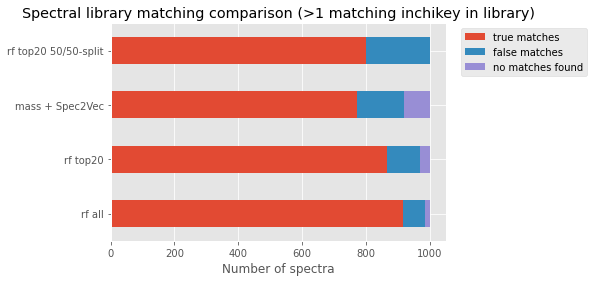

In [132]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
          'rf all',
          'rf top20',
          'rf top20 50/50-split']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_m_s2v_arr == 1), np.sum(test_m_s2v_arr == 0), np.sum(test_m_s2v_arr == -1)],
                [np.sum(test_m_rf_all_arr == 1), np.sum(test_m_rf_all_arr == 0), np.sum(test_m_rf_all_arr == -1)],
               [np.sum(test_m_rf_top20_arr == 1), np.sum(test_m_rf_top20_arr == 0), np.sum(test_m_rf_top20_arr == -1)],
               [np.sum(test_m_rf_top20_5050_arr == 1), np.sum(test_m_rf_top20_5050_arr == 0), np.sum(test_m_rf_top20_5050_arr == -1)]])
  
dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>1 matching inchikey in library)')

### Calculate mass_match again:
    -in bins of 2, 5
    -in a percent change: abs((query-library)/library)*100

In [133]:
from rdkit import Chem, DataStructs

def find_info_matches(matches, documents_library, documents_query,
                      bins = [2, 5], calc_change = False, add_label = True,
                      add_mass_match = True, add_tanimoto_sim = True, add_cols = ['parent_mass']):
    '''
    To each df in matches, add label for matching inchikey and mass matches
    
    A matching inchikey gets label 1 and non-matching 0. Mass matches are represented in discrete 
    bins or as a percentage of mass change.

    matches: list of pandas DataFrames, library matching result of query on library
    documents_library: list of SpectrumDocuments, spectra in library
    documents_query: list of SpectrumDocuments, spectra in query set.
        Indices should correspond to indices of matches.
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    add_label: bool, add a label for inchikey match or not
    add_mass_match: bool, add mass_match info or not
    add_tanimoto_sim: bool, add tanimoto similarity or not
    add_cols: bool/list of str, add other info present in metadata such as parent_mass, adduct
        default: ['parent_mass']
    
    Output
    matches_with_info: list of pandas DataFrames, library matching result of query
        on library with matching labels
    '''
    matches_with_info = []
    for query_id in range(len(documents_query)):
        match = matches[query_id]
        if add_label:
            query_inchi = documents_query[query_id]._obj.get("inchikey")[:14]
            match = find_inchikey_match(match, documents_library, query_inchi)
        if add_mass_match:
            query_mass = documents_query[query_id]._obj.get("parent_mass")
            match = find_mass_matches(match, documents_library, query_mass, bins, calc_change)
        if add_cols:
            match = find_basic_info(match, documents_library, add_cols)
        if add_tanimoto_sim:
            query_smiles = documents_query[query_id]._obj.get("smiles")
            match = find_tanimoto_sim(match, documents_library, query_smiles)
        matches_with_info.append(match)
    return matches_with_info

def find_inchikey_match(matches, documents_library, query_inchi):
    '''To each match in the matches df, add label for matching inchikey (1) or non-matching (0)

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_inchi: str, first 14 symbols of query inchikey
    df: pandas DataFrame, library matching result of query on library with matching labels
    '''
    matches_with_labels = []
    df = matches.copy()
    library_ids = df.index.values
    labels = []
    for lib_id in library_ids:
        lib_inchi = documents_library[lib_id]._obj.get("inchikey")[:14]
        lab = 0
        if query_inchi == lib_inchi:
            lab = 1
        labels.append(lab)
    df['label'] = labels
    return df

def find_mass_matches(matches, documents_library, query_mass, bins = [2, 5], calc_change = False):
    '''
    To each match in matches df, add the mass change of query to match in bins or a percentage change

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    df: pandas DataFrame, library matching result of 1 query on library with mass matches
    '''
    range_bins = range(len(bins)) #calc once
    df = matches.copy()
    library_ids = df.index.values
    masses = [[] for _ in range_bins] #initialise
    mass_changes = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        if calc_change: #calculate a percentage change in parent mass instead of discrete bins
            perc_change = abs(lib_mass - query_mass) / query_mass * 100
            mass_changes.append(perc_change)
        else:
            for bin_i in range_bins:
                cutoff = bins[bin_i]
                lab = 0
                if abs(query_mass - lib_mass) < cutoff:
                    lab = 1
                masses[bin_i].append(lab)
    #add to df
    if calc_change:
        df['perc_mass_change'] = mass_changes
    else:
        for bin_i in range_bins:
            df['mass_match_' + str(bins[bin_i])] = masses[bin_i]
    return df

def find_basic_info(matches, documents_library, add_cols = ['parent_mass']):
    '''
    To each match in matches df, add the info from add_cols entries

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with added info
    '''
    df = matches.copy()
    library_ids = df.index.values
    if add_cols:
        for col in add_cols:
            col_data = []
            for lib_id in library_ids:
                lib_data = documents_library[lib_id]._obj.get(col)
                col_data.append(lib_data)
            df[col] = col_data
    return df

def find_tanimoto_sim(matches, documents_library, query_smiles):
    '''To each match in matches df, add the tanimoto similarity between query and match

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with tanimoto similarities
    '''
    df = matches.copy()
    sims = []
    library_ids = df.index.values
    
    if not query_smiles or query_smiles == "None": # check that query smiles exist
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    ms_q = Chem.MolFromSmiles(query_smiles)
    if not ms_q: #in case something is wrong with smiles
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    
    fp_q = Chem.RDKFingerprint(ms_q)
    for lib_id in library_ids:
        smiles_lib = documents_library[lib_id]._obj.get("smiles")
        if smiles_lib and smiles_lib != "None":
            ms_lib = Chem.MolFromSmiles(smiles_lib)
            if ms_lib:
                fp_lib = Chem.RDKFingerprint(ms_lib)
                score = DataStructs.FingerprintSimilarity(fp_q, fp_lib)
            else: #in case something is wrong with smiles
                score = 0
        else: #in case it doesnt have smiles
            score = 0
        sims.append(score)
    df['similarity'] = sims
    return df


In [134]:
found_matches_s2v_more_info = find_info_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v, bins = [2,5],
                                                add_cols=False, add_tanimoto_sim=False)
found_matches_s2v_mm5_pmass_sim = find_info_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v, bins = [5])
found_matches_s2v_more_info[171].sort_values(by=['s2v_score'], ascending=False).iloc[:20]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
26647      0.998302              13          0.998302                  13   
1652       0.005188               6          0.885819                  15   
27002      0.000000               0          0.387876                  12   
2166       0.006927               5          0.011513                   7   
1636       0.005002               8          0.913320                   9   
1643       0.002817               4          0.902918                  10   
1649       0.158497               5          0.734370                   8   
1647       0.000015               1          0.903097                   9   
27181      0.000132               3          0.000153                   5   
27309      0.000135               1          0.025023                   2   
1631       0.000209               3          0.902313                  10   
27012      0.000000               0          0.846120                  11   
13072      0.000025               4          0.001060                   6   
27469      0.000542               1          0.000542                   1   
27368      0.000000               0          0.000143                   2   
2825       0.000024               3          0.001772                   5   
1193       0.000042               3          0.000042                   3   
27340      0.000773               6          0.010043                  14   
27466      0.000000               0          0.000051                   1   
4602       0.000000               0          0.001828                   2   

       mass_match  s2v_score  label  mass_match_2  mass_match_5  
26647         0.0   0.738719      1             0             0  
1652          0.0   0.607773      0             0             0  
27002         0.0   0.595645      0             0             0  
2166          0.0   0.578534      0             0             0  
1636          0.0   0.562214      0             0             0  
1643          0.0   0.552722      0             0             0  
1649          0.0   0.543317      0             0             0  
1647          0.0   0.540782      0             0             0  
27181         0.0   0.529925      0             0             0  
27309         0.0   0.528484      0             0             0  
1631          0.0   0.523983      0             0             0  
27012         0.0   0.519714      0             0             0  
13072         0.0   0.515517      0             0             0  
27469         0.0   0.514389      0             0             0  
27368         0.0   0.512785      0             0             0  
2825          0.0   0.512240      0             0             0  
1193          0.0   0.509906      0             0             0  
27340         0.0   0.502886      0             0             0  
27466         0.0   0.500744      0             0             0  
4602          0.0   0.499288      0             0             0

In [135]:
#RF with two mass bins extra <2 dalton difference and < 5 dalton difference in parent mass
all_matches_s2v_more_info = found_matches_s2v_more_info[0].append(found_matches_s2v_more_info[1:])
print(all_matches_s2v_more_info.shape, sum(df.shape[0] for df in found_matches_s2v_more_info))
rf_all_more_info = do_random_forest(all_matches_s2v_more_info, 'label', verbose = True, num_est = 200)

(239233, 9) 239233
Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 8)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 8)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {0: 57876, 1: 1933}
Predictions: 
0->0 1->1
56285 1042
0->1 1->0
891 1591
Accuracy: 0.96

Variable: s2v_score            Importance: 0.45
Variable: cosine_score         Importance: 0.19
Variable: mod_cosine_score     Importance: 0.17
Variable: cosine_matches       Importance: 0.07
Variable: mod_cosine_matches   Importance: 0.07
Variable: mass_match           Importance: 0.03
Variable: mass_match_2         Importance: 0.01
Variable: mass_match_5         Importance: 0.01


In [136]:
#RF with parent mass
all_matches_s2v_mm5_pmass = found_matches_s2v_mm5_pmass_sim[0].append(found_matches_s2v_mm5_pmass_sim[1:]).drop('similarity', axis=1)
all_result_mm5_pmass = do_random_forest(all_matches_s2v_mm5_pmass, 'label', verbose = True, num_est = 200)

Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 8)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 8)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {0: 58012, 1: 1797}
Predictions: 
0->0 1->1
56816 1437
0->1 1->0
360 1196
Accuracy: 0.97

Variable: s2v_score            Importance: 0.31
Variable: parent_mass          Importance: 0.24
Variable: cosine_score         Importance: 0.14
Variable: mod_cosine_score     Importance: 0.12
Variable: cosine_matches       Importance: 0.06
Variable: mod_cosine_matches   Importance: 0.06
Variable: mass_match           Importance: 0.04
Variable: mass_match_5         Importance: 0.02


#### Random forest regression

In [137]:
#with mass change perc
found_matches_s2v_match_perc = find_info_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v, calc_change=True, add_tanimoto_sim=False, add_cols=False)
#found_matches_s2v_match_perc[171].sort_values(by=['s2v_score'], ascending=False).iloc[:20]
all_matches_s2v_match_perc = found_matches_s2v_match_perc[0].append(found_matches_s2v_match_perc[1:])
rfreg_all_match_perc = do_random_forest(all_matches_s2v_match_perc, 'label', rf_regr = True,  verbose = True, num_est = 200)

Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 7)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 7)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {0.0: 54269, 0.1: 1298, 0.2: 727, 0.3: 532, 0.4: 443, 0.5: 309, 0.6: 369, 0.7: 440, 0.8: 415, 0.9: 493, 1.0: 514}
Predictions: 
0->0 1->1
56516 1719
0->1 1->0
660 914
Accuracy: 0.97

Variable: perc_mass_change     Importance: 0.5
Variable: s2v_score            Importance: 0.25
Variable: cosine_score         Importance: 0.08
Variable: mod_cosine_score     Importance: 0.08
Variable: cosine_matches       Importance: 0.04
Variable: mod_cosine_matches   Importance: 0.04
Variable: mass_match           Importance: 0.0


In [138]:
df_select = found_matches_s2v_match_perc[171].copy()
dropped_df_select = df_select.drop(['label'],axis=1)
predictions = rfreg_all_match_perc[3].predict(dropped_df_select)
df_select['prediction'] = predictions
df_select['correct_guess'] = (round(df_select['label']) == round(df_select['prediction']))
df_select.sort_values(by=['s2v_score'], ascending=False).iloc[:15]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
26647      0.998302              13          0.998302                  13   
1652       0.005188               6          0.885819                  15   
27002      0.000000               0          0.387876                  12   
2166       0.006927               5          0.011513                   7   
1636       0.005002               8          0.913320                   9   
1643       0.002817               4          0.902918                  10   
1649       0.158497               5          0.734370                   8   
1647       0.000015               1          0.903097                   9   
27181      0.000132               3          0.000153                   5   
27309      0.000135               1          0.025023                   2   
1631       0.000209               3          0.902313                  10   
27012      0.000000               0          0.846120                  11   
13072      0.000025               4          0.001060                   6   
27469      0.000542               1          0.000542                   1   
27368      0.000000               0          0.000143                   2   

       mass_match  s2v_score  label  perc_mass_change  prediction  \
26647         0.0   0.738719      1         96.282100       0.555   
1652          0.0   0.607773      0         47.710866       0.010   
27002         0.0   0.595645      0          0.846164       0.040   
2166          0.0   0.578534      0         35.868966       0.000   
1636          0.0   0.562214      0         42.636756       0.005   
1643          0.0   0.552722      0         42.636925       0.000   
1649          0.0   0.543317      0         37.561971       0.000   
1647          0.0   0.540782      0         47.371149       0.010   
27181         0.0   0.529925      0        190.684295       0.005   
27309         0.0   0.528484      0        178.165667       0.000   
1631          0.0   0.523983      0         42.295518       0.000   
27012         0.0   0.519714      0          3.550879       0.005   
13072         0.0   0.515517      0         24.698384       0.000   
27469         0.0   0.514389      0         95.088271       0.005   
27368         0.0   0.512785      0        190.349144       0.005   

       correct_guess  
26647           True  
1652            True  
27002           True  
2166            True  
1636            True  
1643            True  
1649            True  
1647            True  
27181           True  
27309           True  
1631            True  
27012           True  
13072           True  
27469           True  
27368           True

In [139]:
#visualising performance on the test set
print(rfreg_all_match_perc[0].shape)
test_set_rfreg_all_match_perc = pd.DataFrame(rfreg_all_match_perc[0], columns = cols+['perc_mass_change'])
test_set_rfreg_all_match_perc['label'] = rfreg_all_match_perc[1]
test_set_rfreg_all_match_perc['prediction'] = rfreg_all_match_perc[2]
test_set_rfreg_all_match_perc['correct_guess'] = (round(test_set_rfreg_all_match_perc['label']) == round(test_set_rfreg_all_match_perc['prediction']))
test_set_rfreg_all_match_perc.sort_values(by=['s2v_score'],ascending=False).iloc[:30]

(59809, 7)


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
35122      1.000000            15.0          1.000000                15.0   
34791      1.000000            41.0          1.000000                41.0   
40735      1.000000           123.0          1.000000               123.0   
1733       1.000000            16.0          1.000000                16.0   
40191      1.000000            55.0          1.000000                55.0   
25388      1.000000            49.0          1.000000                49.0   
44288      1.000000            34.0          1.000000                34.0   
26903      1.000000            24.0          1.000000                24.0   
49212      0.999343            16.0          0.999343                16.0   
25597      0.999543            13.0          0.999543                13.0   
16448      0.999735            67.0          0.999753                68.0   
32228      0.999806            61.0          0.999808                62.0   
36591      0.999870            70.0          0.999896                71.0   
4482       0.999829            67.0          0.999829                67.0   
10890      0.999955            72.0          0.999972                73.0   
31930      0.999890            66.0          0.999892                67.0   
21224      0.999842            59.0          0.999842                59.0   
53364      0.999891            61.0          0.999891                61.0   
8183       0.999908            74.0          0.999908                74.0   
27328      0.999741            67.0          0.999741                67.0   
41902      0.999559            64.0          0.999578                65.0   
12282      0.999770            72.0          0.999782                73.0   
11910      0.999868            63.0          0.999868                63.0   
24050      0.999956            61.0          0.999956                61.0   
53201      0.999852            18.0          0.999852                18.0   
29459      0.999944            65.0          0.999957                67.0   
17655      0.999744            63.0          0.999744                63.0   
983        0.999904            58.0          0.999904                58.0   
38689      0.999719            62.0          0.999728                64.0   
27847      0.999834            58.0          0.999834                58.0   

       mass_match  s2v_score  perc_mass_change  label  prediction  \
35122         1.0   1.000000          0.000000      1       1.000   
34791         1.0   1.000000          0.000000      1       0.960   
40735         1.0   1.000000          0.000000      1       0.510   
1733          1.0   1.000000          0.000000      1       1.000   
40191         1.0   1.000000          0.000000      1       0.560   
25388         1.0   1.000000          0.000000      1       0.990   
44288         1.0   1.000000          0.000000      1       0.935   
26903         1.0   1.000000          0.000000      1       1.000   
49212         1.0   0.999699          0.000000      1       1.000   
25597         1.0   0.998715          0.000000      1       0.940   
16448         0.0   0.998407          0.246150      0       0.005   
32228         0.0   0.998219          7.154190      0       0.000   
36591         0.0   0.998122          6.507486      0       0.000   
4482          0.0   0.997947          1.110912      0       0.000   
10890         0.0   0.997897          0.262298      0       0.010   
31930         0.0   0.997840          7.411323      0       0.000   
21224         0.0   0.997809          3.699863      0       0.000   
53364         1.0   0.997776          0.000000      1       0.870   
8183          0.0   0.997749         10.544870      0       0.000   
27328         0.0   0.997732          1.110912      0       0.000   
41902         0.0   0.997677         10.758157      0       0.000   
12282         0.0   0.997638          3.122594      0       0.000   
11910         1.0   0.997598    

In [140]:
#RF regression with parent mass and perc change
found_matches_s2v_match_perc_pmass_sim = find_info_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v, calc_change=True, add_cols = ['parent_mass'])
found_matches_s2v_match_perc_pmass_sim[171].sort_values(by=['s2v_score'], ascending=False).iloc[:20]
all_matches_s2v_match_perc_pmass = found_matches_s2v_match_perc_pmass_sim[0].append(found_matches_s2v_match_perc_pmass_sim[1:]).drop('similarity',axis=1)
rfreg_all_match_perc_pmass = do_random_forest(all_matches_s2v_match_perc_pmass, 'label', rf_regr = True,  verbose = True, num_est = 200)

Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 8)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 8)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {0.0: 54699, 0.1: 1248, 0.2: 635, 0.3: 420, 0.4: 306, 0.5: 242, 0.6: 262, 0.7: 249, 0.8: 285, 0.9: 403, 1.0: 1060}
Predictions: 
0->0 1->1
56807 2013
0->1 1->0
369 620
Accuracy: 0.98

Variable: perc_mass_change     Importance: 0.48
Variable: parent_mass          Importance: 0.19
Variable: s2v_score            Importance: 0.16
Variable: cosine_score         Importance: 0.05
Variable: mod_cosine_score     Importance: 0.05
Variable: cosine_matches       Importance: 0.03
Variable: mod_cosine_matches   Importance: 0.03
Variable: mass_match           Importance: 0.0


In [141]:
import pickle
outfile = os.path.join(path_data, 'rfreg_all_match_perc_pmass.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        rfreg_all_match_perc_pmass = pickle.load(inf)
else:
    with open(outfile, 'wb') as outf:
        pickle.dump(rfreg_all_match_perc_pmass, outf)
        
        
outfile = os.path.join(path_data, 'found_matches_s2v_match_perc_pmass_sim.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v_match_perc_pmass_sim = pickle.load(inf)
else:
    with open(outfile, 'wb') as outf:
        pickle.dump(found_matches_s2v_match_perc_pmass_sim, outf)

C:\Users\joris\Documents\eScience_data\data\rfreg_all_match_perc_pmass.pickle
C:\Users\joris\Documents\eScience_data\data\found_matches_s2v_match_perc_pmass_sim.pickle


#### Linear regression

In [142]:
from sklearn.linear_model import LinearRegression

def do_linear_regression(feature_df, label_name, verbose = True):
    '''Split data in training and test, train regressor, predict on test

    feature_df: pandas DataFrame
    label_name: str, name of the label column in feature_df
    verbose: bool, print more info
    
    Returns test_features, test_labels, predictions, regressor
    '''
    #store labels
    labels = np.array(feature_df[label_name])
    #remove labels
    feature_df_nolab = feature_df.drop(label_name, axis = 1)
    feature_list = list(feature_df_nolab.columns)
    feature_df_nolab = np.array(feature_df_nolab)
    
    #split data in training and test set
    train_features, test_features,\
    train_labels, test_labels = train_test_split(feature_df_nolab, labels,
                                                 test_size = 0.25, random_state = 42)
    if verbose:
        print('Label distribution:', dict(zip(*np.unique(np.round(labels,1), return_counts=True))))
        print('Training Features Shape:', train_features.shape)
        print('Training Labels Shape:', train_labels.shape)
        print('Training label distribution:', dict(zip(*np.unique(np.round(train_labels,1), return_counts=True))))
        print('Testing Features Shape:', test_features.shape)
        print('Testing Labels Shape:', test_labels.shape)
        print('Test label distribution:', dict(zip(*np.unique(np.round(test_labels,1), return_counts=True))))
    
    #train model
    regressor = LinearRegression()
    regressor.fit(train_features, train_labels)
    
    #predict test set
    predictions = regressor.predict(test_features)

    print('\nPredicted label distribution:', dict(zip(*np.unique(np.round(predictions,1), return_counts=True))))
    df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
    print('Predictions:','\n0->0','1->1')
    zero_to_zero = np.sum((df.Actual < 0.5) & (df.Predicted < 0.5))
    one_to_one = np.sum((df.Actual >= 0.5) & (df.Predicted >= 0.5))
    print(zero_to_zero, one_to_one)
    print('0->1','1->0')
    print(np.sum((df.Actual < 0.5) & (df.Predicted >= 0.5)), 
    np.sum((df.Actual >= 0.5) & (df.Predicted < 0.5)))
    print("Accuracy: {:.2f}\n".format((zero_to_zero + one_to_one)/len(predictions)))

    #get feature importances
    importances = list(regressor.coef_)
    #list of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    return (test_features, test_labels, predictions, regressor)

In [143]:
regression_match_perc_pmass = do_linear_regression(all_matches_s2v_match_perc_pmass, 'label')

Label distribution: {0: 228606, 1: 10627}
Training Features Shape: (179424, 8)
Training Labels Shape: (179424,)
Training label distribution: {0: 171430, 1: 7994}
Testing Features Shape: (59809, 8)
Testing Labels Shape: (59809,)
Test label distribution: {0: 57176, 1: 2633}

Predicted label distribution: {-0.5: 2, -0.4: 1, -0.3: 8, -0.2: 67, -0.1: 1800, 0.0: 39411, 0.1: 13802, 0.2: 2115, 0.3: 1178, 0.4: 681, 0.5: 429, 0.6: 315}
Predictions: 
0->0 1->1
56976 322
0->1 1->0
200 2311
Accuracy: 0.96

Variable: s2v_score            Importance: 0.44
Variable: mass_match           Importance: 0.21
Variable: cosine_score         Importance: 0.13
Variable: cosine_matches       Importance: 0.0
Variable: perc_mass_change     Importance: -0.0
Variable: parent_mass          Importance: 0.0
Variable: mod_cosine_score     Importance: -0.01
Variable: mod_cosine_matches   Importance: -0.01


In [144]:
print(all_matches_s2v_labels)
regression_labels = do_linear_regression(all_matches_s2v_labels, 'label')

       cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
1556       0.000000               0          0.000000                   0   
1782       0.000000               0          0.000008                   1   
1828       0.000000               0          0.000000                   0   
1875       0.000000               0          0.000000                   0   
1901       0.000000               0          0.000000                   0   
...             ...             ...               ...                 ...   
89983      0.000000               0          0.000019                   1   
89984      0.000000               0          0.000000                   0   
91479      0.000007               1          0.000701                   3   
91480      0.000012               1          0.000112                   2   
91481      0.000021               1          0.000021                   1   

       mass_match  s2v_score  label  
1556          1.0  -0.088960      0  

In [145]:
regression_labels_top20 = do_linear_regression(top20_found_matches_s2v_labels, 'label')

Label distribution: {0: 16122, 1: 3878}
Training Features Shape: (15000, 6)
Training Labels Shape: (15000,)
Training label distribution: {0: 12115, 1: 2885}
Testing Features Shape: (5000, 6)
Testing Labels Shape: (5000,)
Test label distribution: {0: 4007, 1: 993}

Predicted label distribution: {-0.1: 147, 0.0: 1577, 0.1: 1701, 0.2: 293, 0.4: 14, 0.5: 294, 0.6: 778, 0.7: 196}
Predictions: 
0->0 1->1
3540 736
0->1 1->0
467 257
Accuracy: 0.86

Variable: mass_match           Importance: 0.47
Variable: s2v_score            Importance: 0.29
Variable: cosine_score         Importance: 0.06
Variable: cosine_matches       Importance: 0.0
Variable: mod_cosine_matches   Importance: -0.0
Variable: mod_cosine_score     Importance: -0.03


In [146]:
found_matches_s2v_match_perc_pmass = find_info_matches(found_matches_s2v, documents_library_s2v, documents_query_s2v, calc_change=True, add_cols = ['parent_mass'], add_tanimoto_sim=False)
top20_found_matches_s2v_match_perc_pmass = make_s2v_selection(found_matches_s2v_match_perc_pmass, 20)
regression_labels_match_perc_pmass_top20 = do_linear_regression(top20_found_matches_s2v_match_perc_pmass, 'label')

Label distribution: {0: 16122, 1: 3878}
Training Features Shape: (15000, 8)
Training Labels Shape: (15000,)
Training label distribution: {0: 12115, 1: 2885}
Testing Features Shape: (5000, 8)
Testing Labels Shape: (5000,)
Test label distribution: {0: 4007, 1: 993}

Predicted label distribution: {-0.3: 1, -0.1: 141, -0.0: 1634, 0.1: 1599, 0.2: 343, 0.4: 7, 0.5: 299, 0.6: 789, 0.7: 187}
Predictions: 
0->0 1->1
3533 741
0->1 1->0
474 252
Accuracy: 0.85

Variable: mass_match           Importance: 0.48
Variable: s2v_score            Importance: 0.25
Variable: cosine_score         Importance: 0.07
Variable: cosine_matches       Importance: 0.0
Variable: mod_cosine_matches   Importance: -0.0
Variable: perc_mass_change     Importance: -0.0
Variable: parent_mass          Importance: 0.0
Variable: mod_cosine_score     Importance: -0.02


In [147]:
#regression on oversampled dataset
regression_labels_oversampled = do_linear_regression(all_matches_s2v_oversampled, 'label')

Label distribution: {0: 228606, 1: 228606}
Training Features Shape: (342909, 6)
Training Labels Shape: (342909,)
Training label distribution: {0: 171294, 1: 171615}
Testing Features Shape: (114303, 6)
Testing Labels Shape: (114303,)
Test label distribution: {0: 57312, 1: 56991}

Predicted label distribution: {-2.0: 1, -1.9: 1, -1.8: 1, -1.7: 3, -1.6: 2, -1.5: 3, -1.4: 15, -1.3: 2, -1.2: 7, -1.1: 8, -1.0: 14, -0.9: 27, -0.8: 10, -0.7: 23, -0.6: 24, -0.5: 38, -0.4: 63, -0.3: 91, -0.2: 170, -0.1: 407, -0.0: 771, 0.1: 1825, 0.2: 10479, 0.3: 32479, 0.4: 21263, 0.5: 8827, 0.6: 6284, 0.7: 5614, 0.8: 6389, 0.9: 5973, 1.0: 6456, 1.1: 6908, 1.2: 102, 1.3: 23}
Predictions: 
0->0 1->1
51347 35653
0->1 1->0
5965 21338
Accuracy: 0.76

Variable: s2v_score            Importance: 0.98
Variable: cosine_score         Importance: 0.26
Variable: mass_match           Importance: 0.16
Variable: cosine_matches       Importance: 0.04
Variable: mod_cosine_matches   Importance: -0.04
Variable: mod_cosine_score  

### Plot results querying top20

In [148]:
#try selecting top 20 first

test_m_s2v_top20 = []
test_m_rf_all_top20 = []
test_m_rf_top20_top20= []
test_m_rf_top20_5050_top20= []
test_m_rf_all_more_info_top20 = []
test_m_rf_all_mm5_pmass_top20 = []
test_m_rfreg_all_match_perc_top20 = []
test_m_rfreg_all_match_perc_pmass_top20 = []
test_m_reg_all_top20 = []
test_m_reg_match_perc_pmass_top20 = []
test_m_reg_top20_top20 = []
test_m_rf_oversampled_top20 = []
test_m_reg_oversampled_top20 = []

threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(documents_query_s2v)):
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_m_s2v_top20.append(best_bet)

    #RF all data
    predictions = all_result[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_all_top20.append(best_bet)
    
    #RF with top20
    predictions = results_top20[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_top20_top20.append(best_bet)
    
    #RF with top20 50/50 split
    predictions = results_top20_5050[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_top20_5050_top20.append(best_bet)
    
    #RF all data with more mass match features
    current_match_more_info = found_matches_s2v_more_info[ID].drop('label', axis = 1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rf_all_more_info[3].predict(current_match_more_info)
    #take the predicted match with highest s2v score
    df_select = current_match_more_info.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_all_more_info_top20.append(best_bet)
    
    #RF all data
    current_match_mm5_pmass = found_matches_s2v_mm5_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = all_result_mm5_pmass[3].predict(current_match_mm5_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_mm5_pmass.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_all_mm5_pmass_top20.append(best_bet)
    
    #RF regression all data with perc mass change
    current_match_match_perc = found_matches_s2v_match_perc[ID].drop('label',axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc[3].predict(current_match_match_perc)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rfreg_all_match_perc_top20.append(best_bet)
    
    #RF regression all data with perc mass change and parent mass
    current_match_match_perc_pmass = found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rfreg_all_match_perc_pmass_top20.append(best_bet)
    
    #regression all data
    predictions = regression_labels[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_reg_all_top20.append(best_bet)
    
    #regression all data + mass match perc + parent mass
    predictions = regression_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match_match_perc_pmass.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_reg_match_perc_pmass_top20.append(best_bet)
    
    #regression trained on top 20
    predictions = regression_labels_top20[3].predict(current_match)
    #take the predicted match with highest score above 0.5
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_reg_top20_top20.append(best_bet)
    
    #RF on oversampled data no added features
    predictions = results_all_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_rf_oversampled_top20.append(best_bet)
    
    #regression on oversampled data no added features
    predictions = regression_labels_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_m_reg_oversampled_top20.append(best_bet)
    

# Make arrays from lists:
test_m_s2v_arr_top20 = np.array(test_m_s2v_top20)
test_m_rf_all_arr_top20 = np.array(test_m_rf_all_top20)
test_m_rf_top20_arr_top20 = np.array(test_m_rf_top20_top20)
test_m_rf_top20_5050_arr_top20 = np.array(test_m_rf_top20_5050_top20)
test_m_rf_all_more_info_arr_top20 = np.array(test_m_rf_all_more_info_top20)
test_m_rf_all_mm5_pmass_arr_top20 = np.array(test_m_rf_all_mm5_pmass_top20)
test_m_rfreg_all_match_perc_arr_top20 = np.array(test_m_rfreg_all_match_perc_top20)
test_m_rfreg_all_match_perc_pmass_arr_top20 = np.array(test_m_rfreg_all_match_perc_pmass_top20)
test_m_reg_all_arr_top20 = np.array(test_m_reg_all_top20)
test_m_reg_match_perc_pmass_arr_top20 = np.array(test_m_reg_match_perc_pmass_top20)
test_m_reg_top20_arr_top20 = np.array(test_m_reg_top20_top20)
test_m_rf_oversampled_arr_top20 = np.array(test_m_rf_oversampled_top20)
test_m_reg_oversampled_arr_top20 = np.array(test_m_reg_oversampled_top20)

Text(0.5, 1.0, 'Spectral library matching comparison (>1 matching inchikey in library)')

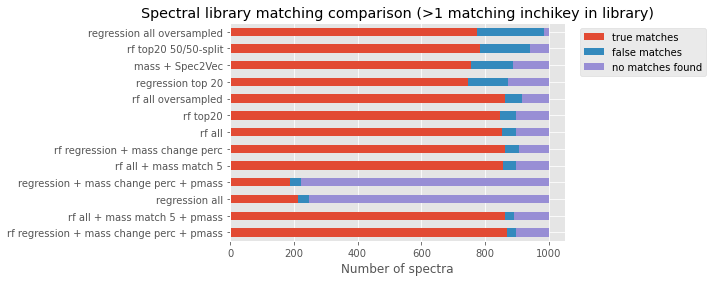

In [149]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'rf all',
           'rf top20',
           'rf top20 50/50-split',
           'rf all + mass match 5',
           'rf all + mass match 5 + pmass',
           'rf regression + mass change perc',
           'rf regression + mass change perc + pmass',
           'regression all',
           'regression + mass change perc + pmass',
           'regression top 20',
           'rf all oversampled',
           'regression all oversampled']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_m_s2v_arr_top20 == 1), np.sum(test_m_s2v_arr_top20 == 0), np.sum(test_m_s2v_arr_top20 == -1)],
                [np.sum(test_m_rf_all_arr_top20 == 1), np.sum(test_m_rf_all_arr_top20 == 0), np.sum(test_m_rf_all_arr_top20 == -1)],
                [np.sum(test_m_rf_top20_arr_top20 == 1), np.sum(test_m_rf_top20_arr_top20 == 0), np.sum(test_m_rf_top20_arr_top20 == -1)],
                [np.sum(test_m_rf_top20_5050_arr_top20 == 1), np.sum(test_m_rf_top20_5050_arr_top20 == 0),
                np.sum(test_m_rf_top20_5050_arr_top20 == -1)],
                [np.sum(test_m_rf_all_more_info_arr_top20 == 1), np.sum(test_m_rf_all_more_info_arr_top20 == 0),
                 np.sum(test_m_rf_all_more_info_arr_top20 == -1)],
                [np.sum(test_m_rf_all_mm5_pmass_arr_top20 == 1), np.sum(test_m_rf_all_mm5_pmass_arr_top20 == 0),
                 np.sum(test_m_rf_all_mm5_pmass_arr_top20 == -1)],
                [np.sum(test_m_rfreg_all_match_perc_arr_top20 == 1), np.sum(test_m_rfreg_all_match_perc_arr_top20 == 0),
                 np.sum(test_m_rfreg_all_match_perc_arr_top20 == -1)],
                [np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                [np.sum(test_m_reg_all_arr_top20 == 1), np.sum(test_m_reg_all_arr_top20 == 0),
                 np.sum(test_m_reg_all_arr_top20 == -1)],
                [np.sum(test_m_reg_match_perc_pmass_arr_top20 == 1), np.sum(test_m_reg_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_m_reg_match_perc_pmass_arr_top20 == -1)],
                [np.sum(test_m_reg_top20_arr_top20 == 1), np.sum(test_m_reg_top20_arr_top20 == 0),
                 np.sum(test_m_reg_top20_arr_top20 == -1)],
                [np.sum(test_m_rf_oversampled_arr_top20 == 1), np.sum(test_m_rf_oversampled_arr_top20 == 0),
                 np.sum(test_m_rf_oversampled_arr_top20 == -1)],
                [np.sum(test_m_reg_oversampled_arr_top20 == 1), np.sum(test_m_reg_oversampled_arr_top20 == 0),
                 np.sum(test_m_reg_oversampled_arr_top20 == -1)]])


dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>1 matching inchikey in library)')

### Plot against new test set (new 1000 queries, queried on new model)

In [202]:
#making new queries data in all different feature datasets
outfile = os.path.join(path_data, 'new_found_matches_s2v_match_perc_pmass_sim.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_found_matches_s2v_match_perc_pmass_sim = pickle.load(inf)
else:
    new_found_matches_s2v_match_perc_pmass_sim = find_info_matches(new_found_matches_s2v, new_documents_library_s2v,
                                                                   new_documents_query_s2v, calc_change=True,
                                                                   add_cols = ['parent_mass'])
    with open(outfile, 'wb') as outf:
        pickle.dump(new_found_matches_s2v_match_perc_pmass_sim, outf)


new_found_matches_s2v_mm5_pmass_sim = find_info_matches(new_found_matches_s2v, new_documents_library_s2v, new_documents_query_s2v, bins = [2, 5], add_cols = ['parent_mass'])

C:\Users\joris\Documents\eScience_data\data\new_found_matches_s2v_match_perc_pmass_sim.pickle


In [155]:
#dropping some columns from above to make all appropriate datasets
new_found_matches_s2v_mm5_pmass_sim[0].sort_values(by=['s2v_score'], ascending=False).iloc[:30]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46341      0.792853               3          0.792853                   3   
52743      0.766401               1          0.766401                   1   
34539      0.241939               1          0.955195                   2   
47562      0.010289               1          0.010289                   1   
35469      0.243206               1          0.243206                   1   
33568      0.000000               0          0.000000                   0   
52554      0.000000               0          0.000000                   0   
47158      0.285278               2          0.285278                   2   
47558      0.032219               1          0.032219                   1   
38527      0.013670               1          0.013693                   2   
52973      0.000008               1          0.000008                   1   
38523      0.036623               1          0.040348                   2   
45757      0.766454               2          0.766454                   2   
51823      0.000000               0          0.000000                   0   
43816      0.010825               1          0.384554                   3   
37029      0.000000               0          0.000000                   0   
37404      0.000000               0          0.000000                   0   
38017      0.000935               1          0.000935                   1   
32638      0.000000               0          0.000000                   0   
37798      0.029850               1          0.033895                   3   
43970      0.634632               1          0.634632                   1   
47182      0.000000               0          0.000000                   0   
31878      0.000735               1          0.000735                   1   
36538      0.000176               1          0.000176                   1   
36319      0.000176               1          0.000176                   1   
39997      0.000000               0          0.000000                   0   
39841      0.000000               0          0.000000                   0   
39051      0.000000               0          0.000000                   0   
39237      0.000000               0          0.000000                   0   
51658      0.000000               0          0.000000                   0   

       mass_match  s2v_score  label  mass_match_2  mass_match_5  parent_mass  \
46341         1.0   0.838697      0             1             1   829.728724   
52743         0.0   0.589020      0             0             0   901.728724   
34539         0.0   0.585604      0             0             1   833.760724   
47562         1.0   0.584888      1             1             1   829.728724   
35469         0.0   0.565561      0             0             1   833.760724   
33568         0.0   0.560947      0             0             1   827.713724   
52554         1.0   0.551094      0             1             1   829.728724   
47158         0.0   0.550833      0             0             0   853.728724   
47558         1.0   0.548738      0             1             1   829.728724   
38527         0.0   0.545742      0             0             1   827.713724   
52973         1.0   0.544748      1             1             1   829.728724   
38523         0.0   0.540438      0             0             0   801.697724   
45757         0.0   0.538008      0             0             0   901.728724   
51823         1.0   0.537810      1             1             1   829.728724   
43816         0.0   0.536827      0             0             0   859.775724   
37029         0.0   0.534970      0             0             0   913.822724   
37404         1.0   0.531860      0             1             1   829.728724   
38017         0.0   0.531845      0             0             0   857.760724   
32638         0.0   0.531173      0             0             0   799.681724   
37798         0.0  

In [156]:
new_found_matches_s2v_mm5_pmass_sim[0].sort_values(by=['s2v_score'], ascending=False).iloc[:30]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46341      0.792853               3          0.792853                   3   
52743      0.766401               1          0.766401                   1   
34539      0.241939               1          0.955195                   2   
47562      0.010289               1          0.010289                   1   
35469      0.243206               1          0.243206                   1   
33568      0.000000               0          0.000000                   0   
52554      0.000000               0          0.000000                   0   
47158      0.285278               2          0.285278                   2   
47558      0.032219               1          0.032219                   1   
38527      0.013670               1          0.013693                   2   
52973      0.000008               1          0.000008                   1   
38523      0.036623               1          0.040348                   2   
45757      0.766454               2          0.766454                   2   
51823      0.000000               0          0.000000                   0   
43816      0.010825               1          0.384554                   3   
37029      0.000000               0          0.000000                   0   
37404      0.000000               0          0.000000                   0   
38017      0.000935               1          0.000935                   1   
32638      0.000000               0          0.000000                   0   
37798      0.029850               1          0.033895                   3   
43970      0.634632               1          0.634632                   1   
47182      0.000000               0          0.000000                   0   
31878      0.000735               1          0.000735                   1   
36538      0.000176               1          0.000176                   1   
36319      0.000176               1          0.000176                   1   
39997      0.000000               0          0.000000                   0   
39841      0.000000               0          0.000000                   0   
39051      0.000000               0          0.000000                   0   
39237      0.000000               0          0.000000                   0   
51658      0.000000               0          0.000000                   0   

       mass_match  s2v_score  label  mass_match_2  mass_match_5  parent_mass  \
46341         1.0   0.838697      0             1             1   829.728724   
52743         0.0   0.589020      0             0             0   901.728724   
34539         0.0   0.585604      0             0             1   833.760724   
47562         1.0   0.584888      1             1             1   829.728724   
35469         0.0   0.565561      0             0             1   833.760724   
33568         0.0   0.560947      0             0             1   827.713724   
52554         1.0   0.551094      0             1             1   829.728724   
47158         0.0   0.550833      0             0             0   853.728724   
47558         1.0   0.548738      0             1             1   829.728724   
38527         0.0   0.545742      0             0             1   827.713724   
52973         1.0   0.544748      1             1             1   829.728724   
38523         0.0   0.540438      0             0             0   801.697724   
45757         0.0   0.538008      0             0             0   901.728724   
51823         1.0   0.537810      1             1             1   829.728724   
43816         0.0   0.536827      0             0             0   859.775724   
37029         0.0   0.534970      0             0             0   913.822724   
37404         1.0   0.531860      0             1             1   829.728724   
38017         0.0   0.531845      0             0             0   857.760724   
32638         0.0   0.531173      0             0             0   799.681724   
37798         0.0  

In [157]:
#try selecting top 40 first

test_new_s2v_top40 = []
test_new_rf_all_top40 = []
test_new_rf_top20_top40= []
test_new_rf_top20_5050_top40= []
test_new_rf_all_more_info_top40 = []
test_new_rf_all_mm5_pmass_top40 = []
test_new_rfreg_all_match_perc_top40 = []
test_new_rfreg_all_match_perc_pmass_top40 = []
test_new_reg_all_top40 = []
test_new_reg_match_perc_pmass_top40 = []
test_new_reg_top20_top40 = []
test_new_rf_oversampled_top40 = []
test_new_reg_oversampled_top40 = []

threshold = 0.4
topn = 40 #only look at top 40

for ID in range(len(new_documents_query_s2v)):
    inchikey_query = new_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = new_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_new_s2v_top40.append(best_bet)

    #RF all data
    predictions = all_result[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_top40.append(best_bet)
    
    #RF with top20
    predictions = results_top20[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_top20_top40.append(best_bet)
    
    #RF with top20 50/50 split
    predictions = results_top20_5050[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_top20_5050_top40.append(best_bet)
    
    #RF all data with more mass match features 2 and 5
    current_match_more_info = new_found_matches_s2v_mm5_pmass_sim[ID]\
        .drop(['label', 'parent_mass', 'similarity'], axis = 1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rf_all_more_info[3].predict(current_match_more_info)
    #take the predicted match with highest s2v score
    df_select = current_match_more_info.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_more_info_top40.append(best_bet)
    
    #RF all data mass match 5 and parent mass
    current_match_mm5_pmass = new_found_matches_s2v_mm5_pmass_sim[ID]\
        .drop(['label', 'similarity', 'mass_match_2'], axis = 1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = all_result_mm5_pmass[3].predict(current_match_mm5_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_mm5_pmass.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_mm5_pmass_top40.append(best_bet)
    
    #RF regression all data with perc mass change
    current_match_match_perc = new_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label','parent_mass'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc[3].predict(current_match_match_perc)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rfreg_all_match_perc_top40.append(best_bet)
    
    #RF regression all data with perc mass change and parent mass
    current_match_match_perc_pmass = new_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rfreg_all_match_perc_pmass_top40.append(best_bet)
    
    #regression all data
    predictions = regression_labels[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_all_top40.append(best_bet)
    
    #regression all data + mass match perc + parent mass
    predictions = regression_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match_match_perc_pmass.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_match_perc_pmass_top40.append(best_bet)
    
    #regression trained on top 20
    predictions = regression_labels_top20[3].predict(current_match)
    #take the predicted match with highest score above 0.5
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_top20_top40.append(best_bet)
    
    #RF on oversampled data no added features
    predictions = results_all_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_oversampled_top40.append(best_bet)
    
    #regression on oversampled data no added features
    predictions = regression_labels_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_oversampled_top40.append(best_bet)

# Make arrays from lists:
test_new_s2v_arr_top40 = np.array(test_new_s2v_top40)
test_new_rf_all_arr_top40 = np.array(test_new_rf_all_top40)
test_new_rf_top20_arr_top40 = np.array(test_new_rf_top20_top40)
test_new_rf_top20_5050_arr_top40 = np.array(test_new_rf_top20_5050_top40)
test_new_rf_all_more_info_arr_top40 = np.array(test_new_rf_all_more_info_top40)
test_new_rf_all_mm5_pmass_arr_top40 = np.array(test_new_rf_all_mm5_pmass_top40)
test_new_rfreg_all_match_perc_arr_top40 = np.array(test_new_rfreg_all_match_perc_top40)
test_new_rfreg_all_match_perc_pmass_arr_top40 = np.array(test_new_rfreg_all_match_perc_pmass_top40)
test_new_reg_all_arr_top40 = np.array(test_new_reg_all_top40)
test_new_reg_match_perc_pmass_arr_top40 = np.array(test_new_reg_match_perc_pmass_top40)
test_new_reg_top20_arr_top40 = np.array(test_new_reg_top20_top40)
test_new_rf_oversampled_arr_top40 = np.array(test_new_rf_oversampled_top40)
test_new_reg_oversampled_arr_top40 = np.array(test_new_reg_oversampled_top40)

Text(0.5, 1.0, 'Spectral library matching comparison new test set looking at top 40\n(>5 matching inchikey in library)')

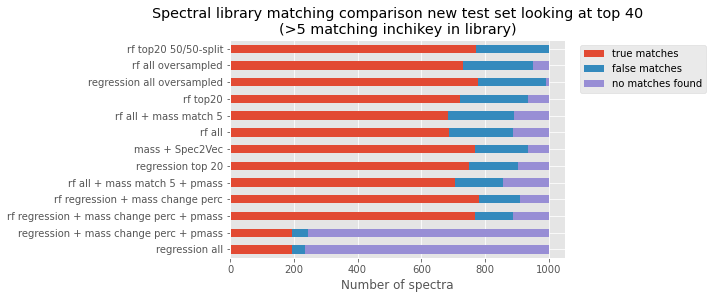

In [158]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'rf all',
           'rf top20',
           'rf top20 50/50-split',
           'rf all + mass match 5',
           'rf all + mass match 5 + pmass',
           'rf regression + mass change perc',
           'rf regression + mass change perc + pmass',
           'regression all',
           'regression + mass change perc + pmass',
           'regression top 20',
           'rf all oversampled',
           'regression all oversampled']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_new_s2v_arr_top40 == 1), np.sum(test_new_s2v_arr_top40 == 0), np.sum(test_new_s2v_arr_top40 == -1)],
                [np.sum(test_new_rf_all_arr_top40 == 1), np.sum(test_new_rf_all_arr_top40 == 0), np.sum(test_new_rf_all_arr_top40 == -1)],
                [np.sum(test_new_rf_top20_arr_top40 == 1), np.sum(test_new_rf_top20_arr_top40 == 0), np.sum(test_new_rf_top20_arr_top40 == -1)],
                [np.sum(test_new_rf_top20_5050_arr_top40 == 1), np.sum(test_new_rf_top20_5050_arr_top40 == 0),
                np.sum(test_new_rf_top20_5050_arr_top40 == -1)],
                [np.sum(test_new_rf_all_more_info_arr_top40 == 1), np.sum(test_new_rf_all_more_info_arr_top40 == 0),
                 np.sum(test_new_rf_all_more_info_arr_top40 == -1)],
                [np.sum(test_new_rf_all_mm5_pmass_arr_top40 == 1), np.sum(test_new_rf_all_mm5_pmass_arr_top40 == 0),
                 np.sum(test_new_rf_all_mm5_pmass_arr_top40 == -1)],
                [np.sum(test_new_rfreg_all_match_perc_arr_top40 == 1), np.sum(test_new_rfreg_all_match_perc_arr_top40 == 0),
                 np.sum(test_new_rfreg_all_match_perc_arr_top40 == -1)],
                [np.sum(test_new_rfreg_all_match_perc_pmass_arr_top40 == 1), np.sum(test_new_rfreg_all_match_perc_pmass_arr_top40 == 0),
                 np.sum(test_new_rfreg_all_match_perc_pmass_arr_top40 == -1)],
                [np.sum(test_new_reg_all_arr_top40 == 1), np.sum(test_new_reg_all_arr_top40 == 0),
                 np.sum(test_new_reg_all_arr_top40 == -1)],
                [np.sum(test_new_reg_match_perc_pmass_arr_top40 == 1), np.sum(test_new_reg_match_perc_pmass_arr_top40 == 0),
                 np.sum(test_new_reg_match_perc_pmass_arr_top40 == -1)],
                [np.sum(test_new_reg_top20_arr_top40 == 1), np.sum(test_new_reg_top20_arr_top40 == 0),
                 np.sum(test_new_reg_top20_arr_top40 == -1)],
                [np.sum(test_new_rf_oversampled_arr_top40 == 1), np.sum(test_new_rf_oversampled_arr_top40 == 0),
                 np.sum(test_new_rf_oversampled_arr_top40 == -1)],
                [np.sum(test_new_reg_oversampled_arr_top40 == 1), np.sum(test_new_reg_oversampled_arr_top40 == 0),
                 np.sum(test_new_reg_oversampled_arr_top40 == -1)]])



dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison new test set looking at top 40\n(>5 matching inchikey in library)')

In [159]:
#try selecting top 20 first

test_new_s2v_top20 = []
test_new_rf_all_top20 = []
test_new_rf_top20_top20= []
test_new_rf_top20_5050_top20= []
test_new_rf_all_more_info_top20 = []
test_new_rf_all_mm5_pmass_top20 = []
test_new_rfreg_all_match_perc_top20 = []
test_new_rfreg_all_match_perc_pmass_top20 = []
test_new_reg_all_top20 = []
test_new_reg_match_perc_pmass_top20 = []
test_new_reg_top20_top20 = []
test_new_rf_oversampled_top20 = []
test_new_reg_oversampled_top20 = []

threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(new_documents_query_s2v)):
    inchikey_query = new_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = new_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_new_s2v_top20.append(best_bet)

    #RF all data
    predictions = all_result[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_top20.append(best_bet)
    
    #RF with top20
    predictions = results_top20[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_top20_top20.append(best_bet)
    
    #RF with top20 50/50 split
    predictions = results_top20_5050[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_top20_5050_top20.append(best_bet)
    
    #RF all data with more mass match features 2 and 5
    current_match_more_info = new_found_matches_s2v_mm5_pmass_sim[ID]\
        .drop(['label', 'parent_mass', 'similarity'], axis = 1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rf_all_more_info[3].predict(current_match_more_info)
    #take the predicted match with highest s2v score
    df_select = current_match_more_info.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_more_info_top20.append(best_bet)
    
    #RF all data mass match 5 and parent mass
    current_match_mm5_pmass = new_found_matches_s2v_mm5_pmass_sim[ID]\
        .drop(['label', 'similarity', 'mass_match_2'], axis = 1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = all_result_mm5_pmass[3].predict(current_match_mm5_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_mm5_pmass.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_all_mm5_pmass_top20.append(best_bet)
    
    #RF regression all data with perc mass change
    current_match_match_perc = new_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label','parent_mass'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc[3].predict(current_match_match_perc)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rfreg_all_match_perc_top20.append(best_bet)
    
    #RF regression all data with perc mass change and parent mass
    current_match_match_perc_pmass = new_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rfreg_all_match_perc_pmass_top20.append(best_bet)
    
    #regression all data
    predictions = regression_labels[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_all_top20.append(best_bet)
    
    #regression all data + mass match perc + parent mass
    predictions = regression_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match_match_perc_pmass.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_match_perc_pmass_top20.append(best_bet)
    
    #regression trained on top 20
    predictions = regression_labels_top20[3].predict(current_match)
    #take the predicted match with highest score above 0.5
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_top20_top20.append(best_bet)
    
    #RF on oversampled data no added features
    predictions = results_all_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    df_select = current_match.iloc[predictions==1]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rf_oversampled_top20.append(best_bet)
    
    #regression on oversampled data no added features
    predictions = regression_labels_oversampled[3].predict(current_match)
    #take the predicted match with highest s2v score
    maxpred = predictions.argmax()
    df_select = current_match.iloc[maxpred]
    if predictions[maxpred] >= 0.5:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        best_match_ID = df_select.name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_reg_oversampled_top20.append(best_bet)

# Make arrays from lists:
test_new_s2v_arr_top20 = np.array(test_new_s2v_top20)
test_new_rf_all_arr_top20 = np.array(test_new_rf_all_top20)
test_new_rf_top20_arr_top20 = np.array(test_new_rf_top20_top20)
test_new_rf_top20_5050_arr_top20 = np.array(test_new_rf_top20_5050_top20)
test_new_rf_all_more_info_arr_top20 = np.array(test_new_rf_all_more_info_top20)
test_new_rf_all_mm5_pmass_arr_top20 = np.array(test_new_rf_all_mm5_pmass_top20)
test_new_rfreg_all_match_perc_arr_top20 = np.array(test_new_rfreg_all_match_perc_top20)
test_new_rfreg_all_match_perc_pmass_arr_top20 = np.array(test_new_rfreg_all_match_perc_pmass_top20)
test_new_reg_all_arr_top20 = np.array(test_new_reg_all_top20)
test_new_reg_match_perc_pmass_arr_top20 = np.array(test_new_reg_match_perc_pmass_top20)
test_new_reg_top20_arr_top20 = np.array(test_new_reg_top20_top20)
test_new_rf_oversampled_arr_top20 = np.array(test_new_rf_oversampled_top20)
test_new_reg_oversampled_arr_top20 = np.array(test_new_reg_oversampled_top20)

Text(0.5, 1.0, 'Spectral library matching comparison new test set looking at top 20\n(>5 matching inchikey in library)')

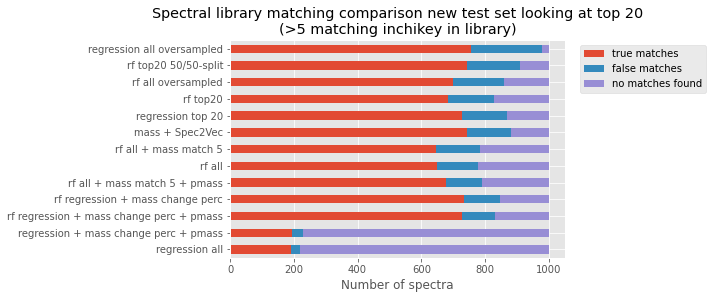

In [160]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'rf all',
           'rf top20',
           'rf top20 50/50-split',
           'rf all + mass match 5',
           'rf all + mass match 5 + pmass',
           'rf regression + mass change perc',
           'rf regression + mass change perc + pmass',
           'regression all',
           'regression + mass change perc + pmass',
           'regression top 20',
           'rf all oversampled',
           'regression all oversampled']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_new_s2v_arr_top20 == 1), np.sum(test_new_s2v_arr_top20 == 0), np.sum(test_new_s2v_arr_top20 == -1)],
                [np.sum(test_new_rf_all_arr_top20 == 1), np.sum(test_new_rf_all_arr_top20 == 0), np.sum(test_new_rf_all_arr_top20 == -1)],
                [np.sum(test_new_rf_top20_arr_top20 == 1), np.sum(test_new_rf_top20_arr_top20 == 0), np.sum(test_new_rf_top20_arr_top20 == -1)],
                [np.sum(test_new_rf_top20_5050_arr_top20 == 1), np.sum(test_new_rf_top20_5050_arr_top20 == 0),
                np.sum(test_new_rf_top20_5050_arr_top20 == -1)],
                [np.sum(test_new_rf_all_more_info_arr_top20 == 1), np.sum(test_new_rf_all_more_info_arr_top20 == 0),
                 np.sum(test_new_rf_all_more_info_arr_top20 == -1)],
                [np.sum(test_new_rf_all_mm5_pmass_arr_top20 == 1), np.sum(test_new_rf_all_mm5_pmass_arr_top20 == 0),
                 np.sum(test_new_rf_all_mm5_pmass_arr_top20 == -1)],
                [np.sum(test_new_rfreg_all_match_perc_arr_top20 == 1), np.sum(test_new_rfreg_all_match_perc_arr_top20 == 0),
                 np.sum(test_new_rfreg_all_match_perc_arr_top20 == -1)],
                [np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                [np.sum(test_new_reg_all_arr_top20 == 1), np.sum(test_new_reg_all_arr_top20 == 0),
                 np.sum(test_new_reg_all_arr_top20 == -1)],
                [np.sum(test_new_reg_match_perc_pmass_arr_top20 == 1), np.sum(test_new_reg_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new_reg_match_perc_pmass_arr_top20 == -1)],
                [np.sum(test_new_reg_top20_arr_top20 == 1), np.sum(test_new_reg_top20_arr_top20 == 0),
                 np.sum(test_new_reg_top20_arr_top20 == -1)],
                [np.sum(test_new_rf_oversampled_arr_top20 == 1), np.sum(test_new_rf_oversampled_arr_top20 == 0),
                 np.sum(test_new_rf_oversampled_arr_top20 == -1)],
                [np.sum(test_new_reg_oversampled_arr_top20 == 1), np.sum(test_new_reg_oversampled_arr_top20 == 0),
                 np.sum(test_new_reg_oversampled_arr_top20 == -1)]])



dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison new test set looking at top 20\n(>5 matching inchikey in library)')

### Trying different test sets

In [161]:
new2_found_matches_s2v_match_perc_pmass_sim = find_info_matches(new2_found_matches_s2v, new2_documents_library_s2v, new2_documents_query_s2v, calc_change=True, add_cols = ['parent_mass'])

In [162]:
new3_found_matches_s2v_match_perc_pmass_sim = find_info_matches(new3_found_matches_s2v, new3_documents_library_s2v, new3_documents_query_s2v, calc_change=True, add_cols = ['parent_mass'])

In [163]:
old_and_unique_found_matches_s2v_match_perc_pmass_sim = find_info_matches(old_and_unique_found_matches_s2v, old_and_unique_documents_library_s2v, old_and_unique_documents_query_s2v, calc_change=True, add_cols = ['parent_mass'])

In [164]:
#make a new rfreg model from the first new training set
all_new_matches_s2v_match_perc_pmass = new_found_matches_s2v_match_perc_pmass_sim[0].append(new_found_matches_s2v_match_perc_pmass_sim[1:]).drop('similarity',axis=1)
rfreg_all_new_match_perc_pmass = do_random_forest(all_new_matches_s2v_match_perc_pmass, 'label', rf_regr = True,  verbose = True, num_est = 500)

Label distribution: {0: 231903, 1: 9151}
Training Features Shape: (180790, 8)
Training Labels Shape: (180790,)
Training label distribution: {0: 173916, 1: 6874}
Testing Features Shape: (60264, 8)
Testing Labels Shape: (60264,)
Test label distribution: {0: 57987, 1: 2277}

Predicted label distribution: {0.0: 55682, 0.1: 1207, 0.2: 530, 0.3: 399, 0.4: 286, 0.5: 274, 0.6: 285, 0.7: 272, 0.8: 278, 0.9: 381, 1.0: 670}
Predictions: 
0->0 1->1
57617 1640
0->1 1->0
370 637
Accuracy: 0.98

Variable: perc_mass_change     Importance: 0.44
Variable: parent_mass          Importance: 0.2
Variable: s2v_score            Importance: 0.16
Variable: cosine_score         Importance: 0.07
Variable: mod_cosine_score     Importance: 0.06
Variable: cosine_matches       Importance: 0.04
Variable: mod_cosine_matches   Importance: 0.04
Variable: mass_match           Importance: 0.0


In [165]:
#This is the new rf reg model on old and new test data

#look at top20
test_old_rfreg_new_all_match_perc_pmass_top20 = []
test_new_rfreg_new_all_match_perc_pmass_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(new_documents_query_s2v)): #I know they have the same length
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    #RF regression all data with perc mass change and parent mass, new rfreg model, old test set
    current_match_match_perc_pmass_old = found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_new_match_perc_pmass[3].predict(current_match_match_perc_pmass_old)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass_old.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_old_rfreg_new_all_match_perc_pmass_top20.append(best_bet)
    
    #RF regression all data with perc mass change and parent mass, new rfreg model, new test set
    inchikey_query = new_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = new_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    
    current_match_match_perc_pmass_new = new_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_new_match_perc_pmass[3].predict(current_match_match_perc_pmass_new)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass_new.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new_rfreg_new_all_match_perc_pmass_top20.append(best_bet)

#make arrays from lists
test_old_rfreg_new_all_match_perc_pmass_arr_top20 = np.array(test_old_rfreg_new_all_match_perc_pmass_top20)
test_new_rfreg_new_all_match_perc_pmass_arr_top20 = np.array(test_new_rfreg_new_all_match_perc_pmass_top20)

In [210]:
#look at top20
test_new2_s2v_top20 = []
test_new2_rfreg_all_match_perc_pmass_top20 = []
test_new2_s2v_same_mass_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(new2_documents_query_s2v)):
    inchikey_query = new2_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = new2_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = new2_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_new2_s2v_top20.append(best_bet)

    #RF regression all data with perc mass change and parent mass
    current_match_match_perc_pmass = new2_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new2_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new2_rfreg_all_match_perc_pmass_top20.append(best_bet)
    
    # mass change 0 + sort by Spec2Vec
    df_select = current_match_match_perc_pmass[(current_match_match_perc_pmass['perc_mass_change'] == 0)
                                  & (current_match_match_perc_pmass['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = new2_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_new2_s2v_same_mass_top20.append(best_bet)

#make arrays from lists
test_new2_s2v_arr_top20 = np.array(test_new2_s2v_top20)
test_new2_rfreg_all_match_perc_pmass_arr_top20 = np.array(test_new2_rfreg_all_match_perc_pmass_top20)
test_new2_s2v_same_mass_arr_top20 = np.array(test_new2_s2v_same_mass_top20)

In [207]:
#look at top20
test_new3_s2v_top20 = []
test_new3_rfreg_all_match_perc_pmass_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(new3_documents_query_s2v)):
    inchikey_query = new3_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = new3_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = new3_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_new3_s2v_top20.append(best_bet)

    #RF regression all data with perc mass change and parent mass
    current_match_match_perc_pmass = new3_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = new3_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_new3_rfreg_all_match_perc_pmass_top20.append(best_bet)

#make arrays from lists
test_new3_s2v_arr_top20 = np.array(test_new3_s2v_top20)
test_new3_rfreg_all_match_perc_pmass_arr_top20 = np.array(test_new3_rfreg_all_match_perc_pmass_top20)

In [168]:
#what if you just take the top hit above a threshold
#look at top20
test_top_hit_s2v_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(documents_query_s2v)):
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: Spec2Vec + threshold
    df_select = current_match[(current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_top_hit_s2v_top20.append(best_bet)


#make arrays from lists
test_top_hit_s2v_arr_top20 = np.array(test_top_hit_s2v_top20)

In [185]:
#just look at mass + mod cosine
#look at top20
test_top_hit_mcos_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(documents_query_s2v)):
    inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = found_matches_s2v[ID].sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['mod_cosine_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_top_hit_mcos_top20.append(best_bet)


#make arrays from lists
test_top_hit_mcos_arr_top20 = np.array(test_top_hit_mcos_top20)

Text(0.5, 1.0, 'Spectral library matching comparison 4 test sets looking at top 20\n(>5 matching inchikey in library)')

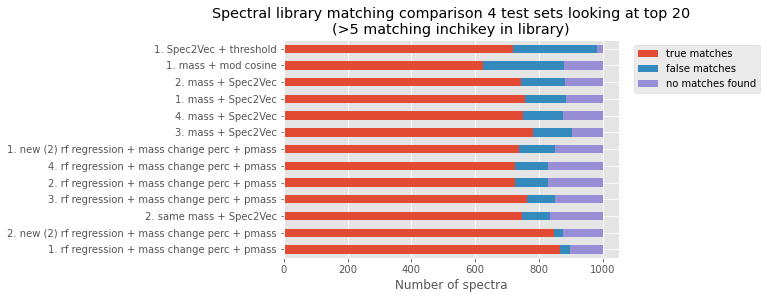

In [211]:
plt.style.use('ggplot')

ylabels = ['1. mass + Spec2Vec',
           '2. mass + Spec2Vec',
           '3. mass + Spec2Vec',
           '4. mass + Spec2Vec',
           '1. mass + mod cosine',
           '1. rf regression + mass change perc + pmass',
           '2. rf regression + mass change perc + pmass',
           '3. rf regression + mass change perc + pmass',
           '4. rf regression + mass change perc + pmass',
           '1. new (2) rf regression + mass change perc + pmass',
           '2. new (2) rf regression + mass change perc + pmass',
           '1. Spec2Vec + threshold',
           '2. same mass + Spec2Vec']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_m_s2v_arr_top20 == 1), np.sum(test_m_s2v_arr_top20 == 0), np.sum(test_m_s2v_arr_top20 == -1)],
                 [np.sum(test_new_s2v_arr_top20 == 1), np.sum(test_new_s2v_arr_top20 == 0), np.sum(test_new_s2v_arr_top20 == -1)],
                 [np.sum(test_new2_s2v_arr_top20 == 1), np.sum(test_new2_s2v_arr_top20 == 0), np.sum(test_new2_s2v_arr_top20 == -1)],
                 [np.sum(test_new3_s2v_arr_top20 == 1), np.sum(test_new3_s2v_arr_top20 == 0), np.sum(test_new3_s2v_arr_top20 == -1)],
                 [np.sum(test_top_hit_mcos_arr_top20 == 1), np.sum(test_top_hit_mcos_arr_top20 == 0), np.sum(test_top_hit_mcos_arr_top20 == -1)],
                 [np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_m_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_new2_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_new2_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new2_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_new3_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_new3_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new3_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_old_rfreg_new_all_match_perc_pmass_arr_top20 == 1), np.sum(test_old_rfreg_new_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_old_rfreg_new_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_new_rfreg_new_all_match_perc_pmass_arr_top20 == 1), np.sum(test_new_rfreg_new_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_new_rfreg_new_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_top_hit_s2v_arr_top20 == 1), np.sum(test_top_hit_s2v_arr_top20 == 0), np.sum(test_top_hit_s2v_arr_top20 == -1)],
                 [np.sum(test_new2_s2v_same_mass_arr_top20 == 1), np.sum(test_new2_s2v_same_mass_arr_top20 == 0), np.sum(test_new2_s2v_same_mass_arr_top20 == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison 4 test sets looking at top 20\n(>5 matching inchikey in library)')

In [208]:
#look at top20
test_old_and_unique_s2v_top20 = []
test_old_and_unique_mcos_top20 = []
test_old_and_unique_s2v_same_mass_top20 = []
test_old_and_unique_rfreg_all_match_perc_pmass_top20 = []
threshold = 0.4
topn = 20 #only look at top 20

for ID in range(len(old_and_unique_documents_query_s2v)):
    inchikey_query = old_and_unique_documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    current_match = old_and_unique_found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    # Scenario 2: mass + sort by Spec2Vec
    df_select = current_match[(current_match['mass_match'] == 1)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = old_and_unique_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_old_and_unique_s2v_top20.append(best_bet)
    
    # mass + sort by mod cosine
    current_match_cos = old_and_unique_found_matches_s2v[ID].sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]
    df_select = current_match_cos[(current_match_cos['mass_match'] == 1)
                                  & (current_match_cos['mod_cosine_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        inchikey_match = old_and_unique_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_old_and_unique_mcos_top20.append(best_bet)

    #RF regression all data new with perc mass change and parent mass
    current_match_match_perc_pmass = old_and_unique_found_matches_s2v_match_perc_pmass_sim[ID].drop(['similarity','label'],axis=1).sort_values(by=['s2v_score'], ascending=False).iloc[:topn]
    predictions = rfreg_all_new_match_perc_pmass[3].predict(current_match_match_perc_pmass)
    #take the predicted match with highest s2v score
    df_select = current_match_match_perc_pmass.iloc[predictions>=0.5]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0].name
        inchikey_selected = old_and_unique_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_selected == inchikey_query)        
    else:
        best_bet = -1 # meaning: not found
    test_old_and_unique_rfreg_all_match_perc_pmass_top20.append(best_bet)
    
    # mass change 0 + sort by Spec2Vec
    df_select = current_match_match_perc_pmass[(current_match_match_perc_pmass['perc_mass_change'] == 0)
                                  & (current_match_match_perc_pmass['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        inchikey_match = old_and_unique_documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        best_bet = 1 * (inchikey_match == inchikey_query)
    else:
        best_bet = -1 # meaning: not found
    test_old_and_unique_s2v_same_mass_top20.append(best_bet)

#make arrays from lists
test_old_and_unique_s2v_arr_top20 = np.array(test_old_and_unique_s2v_top20)
test_old_and_unique_mcos_arr_top20 = np.array(test_old_and_unique_mcos_top20)
test_old_and_unique_rfreg_all_match_perc_pmass_arr_top20 = np.array(test_old_and_unique_rfreg_all_match_perc_pmass_top20)
test_old_and_unique_s2v_same_mass_arr_top20 = np.array(test_old_and_unique_s2v_same_mass_top20)

Text(0.5, 1.0, 'Spectral library matching comparison looking at top 20\n(50% of testset has a match in library)')

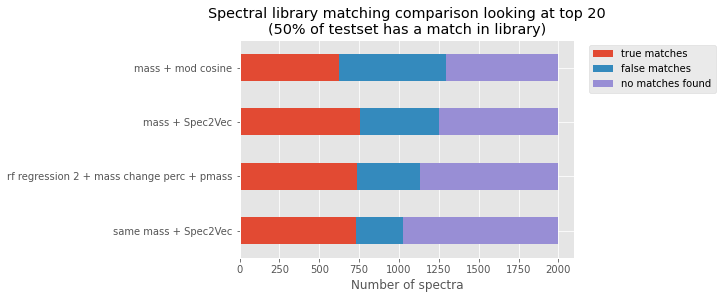

In [212]:
plt.style.use('ggplot')

ylabels = ['mass + Spec2Vec',
           'mass + mod cosine',
           'rf regression 2 + mass change perc + pmass',
           'same mass + Spec2Vec']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_old_and_unique_s2v_arr_top20 == 1), np.sum(test_old_and_unique_s2v_arr_top20 == 0), np.sum(test_old_and_unique_s2v_arr_top20 == -1)],
                 [np.sum(test_old_and_unique_mcos_arr_top20 == 1), np.sum(test_old_and_unique_mcos_arr_top20 == 0), np.sum(test_old_and_unique_mcos_arr_top20 == -1)],
                 [np.sum(test_old_and_unique_rfreg_all_match_perc_pmass_arr_top20 == 1), np.sum(test_old_and_unique_rfreg_all_match_perc_pmass_arr_top20 == 0),
                 np.sum(test_old_and_unique_rfreg_all_match_perc_pmass_arr_top20 == -1)],
                 [np.sum(test_old_and_unique_s2v_same_mass_arr_top20 == 1), np.sum(test_old_and_unique_s2v_same_mass_arr_top20 == 0),
                  np.sum(test_old_and_unique_s2v_same_mass_arr_top20 == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison looking at top 20\n(50% of testset has a match in library)')

### Training for similarity

In [172]:
def convert_similarity_to_label(matches, cutoff = 0.6):
    '''
    Returns the same df with an extra column sim_label that indicates if similarity is above cutoff
    
    matches: list of pandas DataFrames, library matching result of query on library
    cutoff: float, similarity cutoff for creating the new label
    '''
    matches_with_simlab = []
    for match_old in matches:
        match = match_old.copy()
        sims = match['similarity']
        simlabs = [1 if sim >= cutoff else 0 for sim in sims]
        match['sim_label'] = simlabs
        matches_with_simlab.append(match)
    return matches_with_simlab
found_matches_s2v_match_perc_pmass_simlabel = convert_similarity_to_label(found_matches_s2v_match_perc_pmass_sim)

In [173]:
found_matches_s2v_match_perc_pmass_simlabel[0].sort_values(by=['s2v_score'],ascending=False).iloc[:20]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
46003      0.960780               3          0.960780                   3   
38195      0.049197               1          0.971344                   3   
48062      0.043040               2          0.043040                   2   
45969      0.049498               1          0.961919                   2   
32755      0.119678               1          0.608107                   2   
33654      0.944742               2          0.944742                   2   
33166      0.049271               1          0.949622                   2   
30807      0.000000               0          0.961388                   1   
56270      0.000000               0          0.961388                   1   
34114      0.046938               1          0.979920                   2   
56863      0.000000               0          0.961388                   1   
45979      0.000000               0          0.938445                   3   
53958      0.000000               0          0.000000                   0   
57799      0.000000               0          0.961388                   1   
33190      0.045540               1          0.982362                   3   
38480      0.000000               0          0.961388                   1   
38277      0.000000               0          0.961388                   1   
32721      0.000000               0          0.961388                   1   
56286      0.000000               0          0.961388                   1   
45044      0.000000               0          0.961388                   1   

       mass_match  s2v_score  label  perc_mass_change  parent_mass  \
46003         1.0   0.887800      1          0.000000   508.340724   
38195         0.0   0.858902      0          2.757206   522.356724   
48062         0.0   0.848561      0          1.567649   516.309724   
45969         0.0   0.844523      0          8.271421   466.293724   
32755         0.0   0.811812      0          2.757206   522.356724   
33654         1.0   0.799576      1          0.000000   508.340724   
33166         0.0   0.790485      0          8.271421   466.293724   
30807         0.0   0.760594      0          9.083475   554.515724   
56270         0.0   0.747925      0         25.626316   638.609724   
34114         0.0   0.739805      0          2.757206   494.324724   
56863         0.0   0.735438      0         31.140531   666.640724   
45979         0.0   0.732793      0          3.153593   492.309724   
53958         0.0   0.730020      0         27.994019   650.645724   
57799         0.0   0.728967      0         22.479804   622.614724   
33190         0.0   0.727989      0          2.757206   494.324724   
38480         0.0   0.726993      0         27.994019   650.645724   
38277         0.0   0.724805      0          5.936963   538.520724   
32721         0.0   0.724702      0         11.406719   566.325724   
56286         0.0   0.724587      0         31.140531   666.640724   
45044         0.0   0.721622      0         22.479804   622.614724   

       similarity  sim_label  
46003    1.000000          1  
38195    0.774278          1  
48062    0.907563          1  
45969    0.774278          1  
32755    0.774278          1  
33654    1.000000          1  
33166    0.774278          1  
30807    0.170132          0  
56270    0.170132          0  
34114    0.774278          1  
56863    0.170132          0  
45979    0.944606          1  
53958    0.175758          0  
57799    0.175758          0  
33190    0.774278          1  
38480    0.175758          0  
38277    0.175758          0  
32721    0.797844          1  
56286    0.170132          0  
45044    0.175758          0

In [174]:
all_found_matches_s2v_match_perc_pmass_simlabel = found_matches_s2v_match_perc_pmass_simlabel[0].append(found_matches_s2v_match_perc_pmass_simlabel[1:])

all_found_matches_s2v_match_perc_pmass_simlabel_drop = all_found_matches_s2v_match_perc_pmass_simlabel.drop(['label','similarity'],axis=1)

In [175]:
all_found_matches_s2v_match_perc_pmass_simlabel_drop.sort_values('s2v_score',ascending=False)

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
65637      1.000000              11          1.000000                  11   
40198      1.000000              37          1.000000                  37   
40059      1.000000              80          1.000000                  80   
69565      1.000000              15          1.000000                  15   
66426      1.000000              54          1.000000                  54   
...             ...             ...               ...                 ...   
1265       0.000000               0          0.000000                   0   
30366      0.000000               0          0.000000                   0   
38243      0.000005               1          0.000005                   1   
32419      0.000000               0          0.000000                   0   
90987      0.000000               0          0.000000                   0   

       mass_match  s2v_score  perc_mass_change  parent_mass  sim_label  
65637         1.0   1.000000          0.000000   191.130724          1  
40198         1.0   1.000000          0.000000   789.697724          1  
40059         1.0   1.000000          0.000000   832.585724          1  
69565         1.0   1.000000          0.000000   844.305724          1  
66426         1.0   1.000000          0.000000   202.106724          1  
...           ...        ...               ...          ...        ...  
1265          1.0  -0.243909          0.002615   344.116724          0  
30366         1.0  -0.245904          0.145163   567.499724          0  
38243         1.0  -0.265501          0.000000   730.539724          1  
32419         1.0  -0.265508          0.000000   730.539724          1  
90987         1.0  -0.275764          0.020131   422.142724          0  

[239233 rows x 9 columns]

In [176]:
rfreg_all_match_perc_pmass_simlabel = do_random_forest(all_found_matches_s2v_match_perc_pmass_simlabel_drop,
                                                       'sim_label', rf_regr = True,  verbose = True, num_est = 200)

Label distribution: {0: 216573, 1: 22660}
Training Features Shape: (179424, 8)
Training Labels Shape: (179424,)
Training label distribution: {0: 162428, 1: 16996}
Testing Features Shape: (59809, 8)
Testing Labels Shape: (59809,)
Test label distribution: {0: 54145, 1: 5664}

Predicted label distribution: {0.0: 49518, 0.1: 2621, 0.2: 1130, 0.3: 622, 0.4: 569, 0.5: 430, 0.6: 456, 0.7: 404, 0.8: 562, 0.9: 710, 1.0: 2787}
Predictions: 
0->0 1->1
53656 4650
0->1 1->0
489 1014
Accuracy: 0.97

Variable: perc_mass_change     Importance: 0.48
Variable: parent_mass          Importance: 0.19
Variable: s2v_score            Importance: 0.18
Variable: mod_cosine_score     Importance: 0.05
Variable: cosine_score         Importance: 0.04
Variable: cosine_matches       Importance: 0.03
Variable: mod_cosine_matches   Importance: 0.03
Variable: mass_match           Importance: 0.0


In [177]:
#visualising performance on the test set
test_set_rfreg_all_match_perc_pmass_simlabel = pd.DataFrame(rfreg_all_match_perc_pmass_simlabel[0], columns = cols+['perc_mass_change','parent_mass'])
test_set_rfreg_all_match_perc_pmass_simlabel['sim_label'] = rfreg_all_match_perc_pmass_simlabel[1]
test_set_rfreg_all_match_perc_pmass_simlabel['prediction'] = rfreg_all_match_perc_pmass_simlabel[2]
test_set_rfreg_all_match_perc_pmass_simlabel['correct_guess'] = (round(test_set_rfreg_all_match_perc_pmass_simlabel['sim_label']) == round(test_set_rfreg_all_match_perc_pmass_simlabel['prediction']))
test_set_rfreg_all_match_perc_pmass_simlabel.sort_values(by=['s2v_score'],ascending=False).iloc[:20]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
35122      1.000000            15.0          1.000000                15.0   
34791      1.000000            41.0          1.000000                41.0   
40735      1.000000           123.0          1.000000               123.0   
1733       1.000000            16.0          1.000000                16.0   
40191      1.000000            55.0          1.000000                55.0   
25388      1.000000            49.0          1.000000                49.0   
44288      1.000000            34.0          1.000000                34.0   
26903      1.000000            24.0          1.000000                24.0   
49212      0.999343            16.0          0.999343                16.0   
25597      0.999543            13.0          0.999543                13.0   
16448      0.999735            67.0          0.999753                68.0   
32228      0.999806            61.0          0.999808                62.0   
36591      0.999870            70.0          0.999896                71.0   
4482       0.999829            67.0          0.999829                67.0   
10890      0.999955            72.0          0.999972                73.0   
31930      0.999890            66.0          0.999892                67.0   
21224      0.999842            59.0          0.999842                59.0   
53364      0.999891            61.0          0.999891                61.0   
8183       0.999908            74.0          0.999908                74.0   
27328      0.999741            67.0          0.999741                67.0   

       mass_match  s2v_score  perc_mass_change  parent_mass  sim_label  \
35122         1.0   1.000000          0.000000   844.305724          1   
34791         1.0   1.000000          0.000000   203.130724          1   
40735         1.0   1.000000          0.000000   451.185724          1   
1733          1.0   1.000000          0.000000   212.025724          1   
40191         1.0   1.000000          0.000000   199.077724          1   
25388         1.0   1.000000          0.000000   913.822724          1   
44288         1.0   1.000000          0.000000   242.094724          1   
26903         1.0   1.000000          0.000000   532.303724          1   
49212         1.0   0.999699          0.000000   175.048724          1   
25597         1.0   0.998715          0.000000   320.209724          1   
16448         0.0   0.998407          0.246150   816.591724          1   
32228         0.0   0.998219          7.154190   727.575724          1   
36591         0.0   0.998122          6.507486   718.575724          1   
4482          0.0   0.997947          1.110912   827.700724          0   
10890         0.0   0.997897          0.262298   766.575724          1   
31930         0.0   0.997840          7.411323   725.560724          1   
21224         0.0   0.997809          3.699863   729.591724          1   
53364         1.0   0.997776          0.000000   757.622724          1   
8183          0.0   0.997749         10.544870   687.544724          0   
27328         0.0   0.997732          1.110912   827.700724          0   

       prediction  correct_guess  
35122       1.000           True  
34791       0.845           True  
40735       0.970           True  
1733        0.645           True  
40191       0.845           True  
25388       1.000           True  
44288       0.705           True  
26903       1.000           True  
49212       0.920           True  
25597       1.000           True  
16448       0.800           True  
32228       0.635           True  
36591       0.780           True  
4482        0.800          False  
10890       0.885           True  
31930       0.760           True  
21224       0.780           True  
53364       1.000           True  
8183        0.570          False  
27328       0.785          False

In [178]:
#try to see performance for each bin of prediction label (bin 0.7 -> correctly predicted 60%, uncorrect 40% something like this)

test_set_rfreg_all_match_perc_pmass_simlabel

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
0          0.001929             9.0          0.001929                 9.0   
1          0.003362            15.0          0.004176                24.0   
2          0.000000             0.0          0.003422                 1.0   
3          0.000000             0.0          0.000000                 0.0   
4          0.000478             7.0          0.000478                 7.0   
...             ...             ...               ...                 ...   
59804      0.003739            13.0          0.004599                15.0   
59805      0.000933             2.0          0.019546                 4.0   
59806      0.000000             0.0          0.000000                 0.0   
59807      0.985551            20.0          0.985551                20.0   
59808      0.000000             0.0          0.000000                 0.0   

       mass_match  s2v_score  perc_mass_change  parent_mass  sim_label  \
0             1.0   0.069848          0.012843   358.211724          0   
1             1.0   0.213126          0.008842   260.104724          0   
2             1.0   0.047706          0.476897   194.080724          0   
3             1.0   0.003400          0.029544   494.324724          0   
4             1.0   0.026660          0.067087   392.292724          0   
...           ...        ...               ...          ...        ...   
59804         1.0   0.048225          0.083488   861.676724          0   
59805         1.0   0.086335          0.440943   220.041724          0   
59806         1.0   0.000484          0.094323   317.293724          0   
59807         1.0   0.856380          0.000000   550.095724          1   
59808         1.0  -0.053099          0.108389   593.514724          0   

       prediction  correct_guess  
0            0.00           True  
1            0.00           True  
2            0.01           True  
3            0.00           True  
4            0.00           True  
...           ...            ...  
59804        0.00           True  
59805        0.00           True  
59806        0.00           True  
59807        1.00           True  
59808        0.00           True  

[59809 rows x 11 columns]

### Investigate missing mass matches for matching labels

In [179]:
#find a spectrum with true matches but without mass_matches
all_trues = []
inds = []
for ind in range(len(found_matches_s2v)):
    
    predi = all_result[3].predict(found_matches_s2v[ind])
    dfi = found_matches_s2v_labels[ind].copy()
    dfi['prediction'] = predi
    sorts2v = dfi.sort_values(by=['s2v_score'], ascending=False).iloc[:20]
    select = sorts2v[(sorts2v['label']==1) & (sorts2v['prediction']==0) & (sorts2v['mass_match']==0)]
    if select.shape[0] > 0:
        all_true = all(np.array(sorts2v.iloc[0])==np.array(select.iloc[0]))
        print(ind, all_true) #if top select is top match
        inds.append(ind)
        if all_true:
            all_trues.append(ind)
len(all_trues)
len(inds)

18 False
25 False
29 False
30 False
32 False
33 True
44 False
48 False
50 False
56 False
75 False
81 False
82 False
91 False
93 False
94 False
101 True
103 False
113 True
124 False
126 False
152 False
155 False
158 False
171 True
173 False
183 False
186 False
196 False
204 False
214 False
215 False
222 False
224 False
227 False
231 True
232 True
233 False
237 False
249 False
275 False
279 False
280 False
283 False
287 False
292 False
297 False
298 False
300 False
303 False
304 True
307 False
310 False
315 False
336 False
337 False
338 False
343 False
364 False
366 False
373 False
388 False
389 False
393 False
401 False
406 False
412 False
417 False
419 False
420 False
427 False
430 False
449 True
455 False
464 False
473 False
531 False
540 False
543 True
556 False
568 False
572 True
591 False
593 False
597 False
604 False
613 False
623 False
625 False
631 False
635 False
636 False
640 False
641 False
649 False
657 False
659 False
661 False
662 False
663 True
665 False
666 False
676 Fal

154

In [180]:
ind = 18
predi = all_result[3].predict(found_matches_s2v[ind])
dfi = found_matches_s2v_labels[ind].copy()
dfi['prediction'] = predi
sorts2v = dfi.sort_values(by=['s2v_score'], ascending=False).iloc[:20]
sorts2v

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
66633      0.664616              45          0.750967                  50   
66795      0.608122              39          0.639218                  43   
66678      0.094834              38          0.249452                  45   
64335      0.023554              37          0.058843                  48   
66152      0.023938              32          0.028580                  60   
66722      0.023938              32          0.028580                  60   
66744      0.049016              27          0.050029                  38   
64311      0.049016              27          0.050029                  38   
66727      0.005148              16          0.119018                  28   
68782      0.245597              18          0.346483                  23   
62839      0.003691              11          0.035250                  26   
64229      0.007235              13          0.306120                  26   
62566      0.000207               5          0.226556                  14   
64271      0.042544              28          0.047961                  40   
68768      0.042544              28          0.047961                  40   
63474      0.000081               2          0.062082                  13   
63569      0.000405               2          0.014027                  13   
63564      0.000181               3          0.007369                   7   
64097      0.000000               0          0.009182                  10   
63690      0.000307               2          0.011019                   6   

       mass_match  s2v_score  label  prediction  
66633         0.0   0.825818      1           1  
66795         0.0   0.770255      1           1  
66678         0.0   0.697615      1           1  
64335         0.0   0.654275      0           0  
66152         0.0   0.653601      0           0  
66722         0.0   0.653601      0           0  
66744         0.0   0.651371      0           0  
64311         0.0   0.651371      0           0  
66727         0.0   0.639592      0           0  
68782         0.0   0.635570      1           0  
62839         0.0   0.632343      0           0  
64229         0.0   0.626987      0           0  
62566         0.0   0.624334      0           0  
64271         0.0   0.609262      0           0  
68768         0.0   0.608923      0           0  
63474         0.0   0.607861      0           0  
63569         0.0   0.607152      0           0  
63564         0.0   0.592299      0           0  
64097         0.0   0.590802      0           0  
63690         0.0   0.586521      0           0

In [181]:
#check out query 18 which does not have mass matches but is a true match
print(documents_query_s2v[18]._obj._metadata)
print((documents_library_s2v[66633]._obj._metadata))
##they are different..? but the same compound? how.
smiles1 = documents_query_s2v[18]._obj._metadata.get("smiles")
smiles2 = documents_library_s2v[66633]._obj._metadata.get("smiles")
smiles3 = documents_library_s2v[66795]._obj._metadata.get("smiles")

from rdkit import Chem, DataStructs
ms = [Chem.MolFromSmiles(smiles1), Chem.MolFromSmiles(smiles2), Chem.MolFromSmiles(smiles3)]
fps = [Chem.RDKFingerprint(x) for x in ms]

{'spectrum_id': 'CCMSLIB00000221190', 'source_file': 'Massbank_ESI_positive_8_1_2014_peaks.mgf', 'task': '2b0fcfed18d74148aa284e857bb00e4d', 'scan': '-1', 'ms_level': '2', 'library_membership': 'MASSBANK', 'spectrum_status': '1', 'splash': 'splash10-03dm-0896000000-0896000000', 'submit_user': 'mwang87', 'compound_name': 'E-64', 'ion_source': 'ESI', 'compound_source': 'Isolated', 'instrument': 'LC-ESI-IT', 'pi': 'Putative Massbank Match', 'data_collector': 'Massbank', 'adduct': '[M+H]+', 'precursor_mz': 358.0, 'exactmass': '0.0', 'charge': 1, 'cas_number': '66701-25-5', 'pubmed_id': 'N/A', 'smiles': 'NC(=N)NCCCCNC(=O)C(CC(C)C)NC(=O)C(O1)C(C(O)=O)1', 'inchi': 'InChI=1S/C15H27N5O5/c1-8(2)7-9(20-13(22)10-11(25-10)14(23)24)12(21)18-5-3-4-6-19-15(16)17/h8-11H,3-7H2,1-2H3,(H,18,21)(H,20,22)(H,23,24)(H4,16,17,19)', 'inchiaux': 'N/A', 'library_class': '3', 'spectrumid': 'CCMSLIB00000221190', 'ionmode': 'positive', 'create_time': '2014-08-01 16:31:38.0', 'task_id': '2b0fcfed18d74148aa284e857bb00

Inchikeys are matching: True
Parent masses: 356.9927235480092 328.9927235480092 339.9927235480092


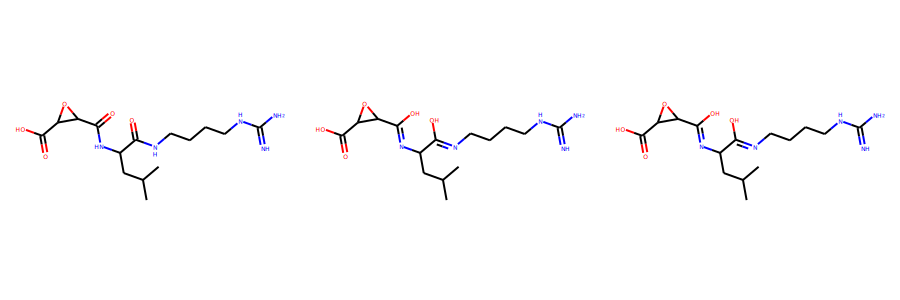

In [182]:
print("Inchikeys are matching:",
      documents_query_s2v[18]._obj._metadata.get("inchikey") == documents_library_s2v[66633]._obj._metadata.get("inchikey"))
print("Parent masses:",
      documents_query_s2v[18]._obj._metadata.get("parent_mass"),
      documents_library_s2v[66633]._obj._metadata.get("parent_mass"),
      documents_library_s2v[66795]._obj._metadata.get("parent_mass"))
img = Chem.Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(300, 300), maxMols=len(ms),
                           legends=None, useSVG=True)
img